# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.

**Important Notes**:
1. Be sure to **document** all of your decisions, as well as your intermediate and final results. Make sure your conclusions and analyses are clearly presented. Don't make us dig into your code or walls of printed results to try to draw conclusions from your code.
2. If you use code from someone else (e.g. Github, Stack Overflow, ChatGPT, etc) you **must be transparent about it**. Document your sources and explain how you adapted any partial solutions to creat **your** solution.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [1]:
import torch

print(torch.__version__)




2.5.1


In [2]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import wandb

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [3]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [4]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy())
        
    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [5]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])
    
    def forward(self, x):
        return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

print(MLP([784, 100, 10]))

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=10, bias=True)
  )
)


#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

Training epoch 99: 100%|██████████| 430/430 [00:02<00:00, 158.74it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.961     0.974     0.968       980
           1      0.976     0.983     0.980      1135
           2      0.957     0.936     0.947      1032
           3      0.910     0.948     0.928      1010
           4      0.958     0.958     0.958       982
           5      0.936     0.930     0.933       892
           6      0.954     0.950     0.952       958
           7      0.959     0.945     0.951      1028
           8      0.928     0.925     0.926       974
           9      0.951     0.938     0.944      1009

    accuracy                          0.949     10000
   macro avg      0.949     0.949     0.949     10000
weighted avg      0.949     0.949     0.949     10000



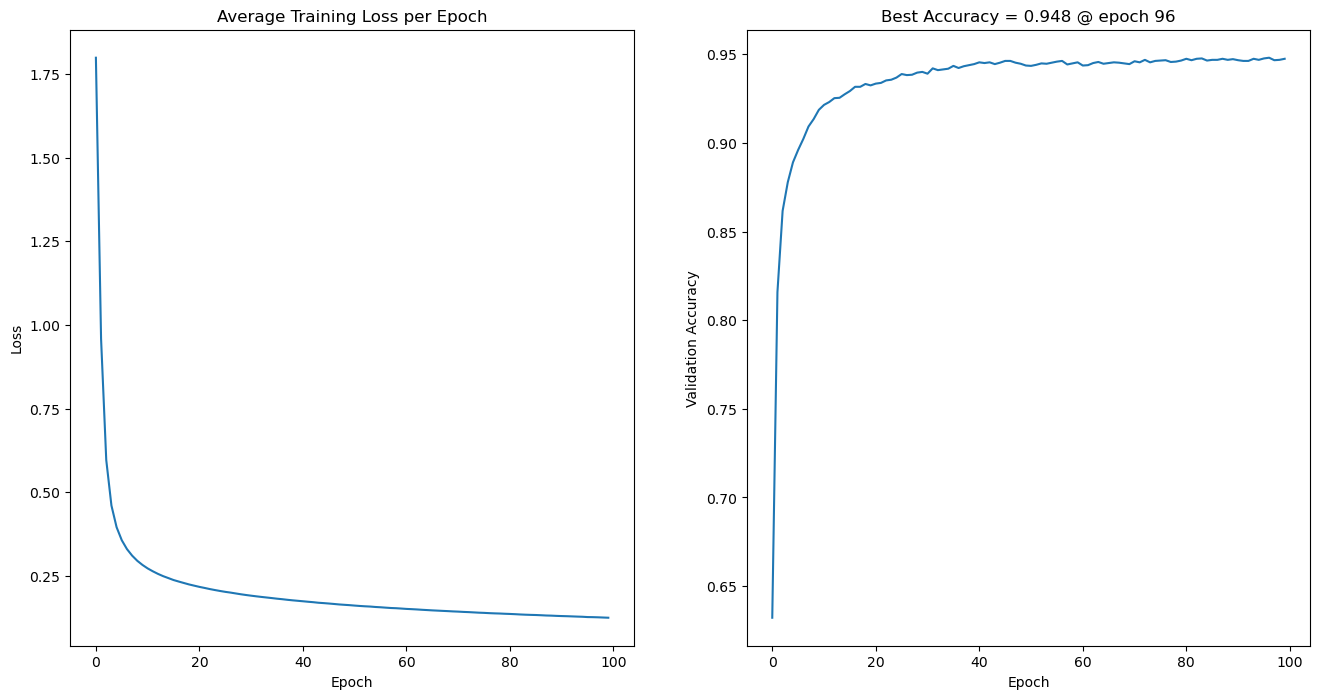

In [6]:
# Training hyperparameters.
device = 'cuda' if torch.cuda.is_available else 'cpu'
epochs = 100
lr = 0.0001
batch_size = 128

# Architecture hyperparameters.
input_size = 28*28
width = 16
depth = 2

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# Instantiate model and optimizer.
model_mlp = MLP([input_size] + [width]*depth + [10]).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Training loop.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, opt, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, dl_test, device=device)[1]}')

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [7]:
class my_MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(my_MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.flatten(1) # MLP requires a 1D input
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    

In [8]:
def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, device):
    train_losses = []
    val_accuracies = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
                
            optimizer.step()
            train_loss += loss.item()
            
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        (val_acc, val_loss, _) = evaluate(model, val_loader, device, criterion)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)
        
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "learning_rate": optimizer.param_groups[0]['lr']
        })
        
        print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    return train_losses, val_accuracies, val_losses
    
def evaluate(model, data_loader, device, criterion=None, log_wandb=False):
    model.eval()
    predictions = []
    gts = []
    class_names = [str(i) for i in range(10)]
    total_loss = 0.0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if criterion is not None:
                loss = criterion(output, target)
                total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            predictions.extend(predicted.cpu().numpy())
            gts.extend(target.cpu().numpy())
    accuracy = accuracy_score(gts, predictions)*100
    if criterion is not None:
        avg_loss = total_loss / len(data_loader)
        wandb.log({
            "val_loss": avg_loss
        })
    else:
        avg_loss = None

    report = classification_report(gts, predictions, zero_division=0, digits=3)
    wandb.log({
        "classification_report": report
    })
    wandb.log({
        "confusion_matrix": wandb.plot.confusion_matrix(
            preds=predictions,
            y_true=gts,
            class_names=class_names
        )
    })
    return accuracy, avg_loss, report

def plot_training_metrics(train_losses, val_accuracies, val_losses=None, save_path=None, model_name=None, model_depth=None):
    epochs = range(1, len(train_losses) + 1)
    
    # Crea subplots
    if val_losses is not None:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    else:

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    if model_name is not None:
        # Plot 1: Training Loss
        ax1.plot(epochs, train_losses, 'b-', label=f'Training Loss ({model_name}, Depth ({model_depth}))', linewidth=2)
        ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        # Plot 2: Validation Accuracy
        ax2.plot(epochs, val_accuracies, 'g-', label=f'Validation Accuracy ({model_name}, Depth ({model_depth}))', linewidth=2)
        ax2.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.grid(True, alpha=0.3)
        ax2.legend()

        # Plot 3: Validation Loss (se fornita)
        if val_losses is not None:
            ax3.plot(epochs, val_losses, 'r-', label=f'Validation Loss ({model_name}, Depth ({model_depth}))', linewidth=2)
            ax3.set_title('Validation Loss', fontsize=14, fontweight='bold')
            ax3.set_xlabel('Epoch')
            ax3.set_ylabel('Loss')
            ax3.grid(True, alpha=0.3)
            ax3.legend()

    else:
        ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
        ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        # Plot 2: Validation Accuracy
        ax2.plot(epochs, val_accuracies, 'g-', label='Validation Accuracy', linewidth=2)
        ax2.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.grid(True, alpha=0.3)
        ax2.legend()

            # Plot 3: Validation Loss (se fornita)
        if val_losses is not None:
            ax3.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
            ax3.set_title('Validation Loss', fontsize=14, fontweight='bold')
            ax3.set_xlabel('Epoch')
            ax3.set_ylabel('Loss')
            ax3.grid(True, alpha=0.3)
            ax3.legend()

    plt.tight_layout()
    
    # Salva se richiesto
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot salvato in: {save_path}")
    
    plt.show()

"""def plot_gradient_magnitude(model, epoch=None, wandb_log=True):
    grad_magnitudes = []
    
    # Raccogli i gradienti
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_magnitude = torch.norm(param.grad).item()
            grad_magnitudes.append((name, grad_magnitude))
    
    if not grad_magnitudes:  # Se non ci sono gradienti, esci
        print("No gradients found")
        return
        
    plt.figure(figsize=(10, 6))
    
    # Preparazione dati
    names = [x[0] for x in grad_magnitudes]
    magnitudes = [x[1] for x in grad_magnitudes]
    
    # Crea il plot a punti
    colors = plt.cm.viridis(range(len(magnitudes)))  # Colori diversi per ogni punto
    scatter = plt.scatter(range(len(magnitudes)), magnitudes, 
                         c=colors, s=100, alpha=0.7, edgecolors='black')
    
    # Connetti i punti con una linea
    plt.plot(range(len(magnitudes)), magnitudes, '--', alpha=0.5, color='gray')
    
    # Formattazione
    plt.xticks(range(len(magnitudes)), names, rotation=45, ha='right')
    plt.yscale('log')  # Scala logaritmica per visualizzare meglio i gradienti
    
    # Aggiungi valori accanto ai punti
    for i, (name, magnitude) in enumerate(grad_magnitudes):
        plt.annotate(f'{magnitude:.3f}', 
                    (i, magnitude), 
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    # Labels e titolo
    plt.ylabel('Gradient Magnitude (L2 norm)')
    plt.xlabel('Layer')
    if epoch is not None:
        plt.title(f'Gradient Magnitudes at Epoch {epoch}')
    else:
        plt.title('Gradient Magnitudes Across Layers')
    
    # Aggiungi griglia per migliore leggibilità
    plt.grid(True, alpha=0.3)
    
    # Migliora layout
    plt.tight_layout()
    
    if wandb_log and len(grad_magnitudes) > 0:
        wandb.log({"gradient_magnitudes": wandb.Image(plt)})
    
    plt.show()"""

'def plot_gradient_magnitude(model, epoch=None, wandb_log=True):\n    grad_magnitudes = []\n    \n    # Raccogli i gradienti\n    for name, param in model.named_parameters():\n        if param.grad is not None:\n            grad_magnitude = torch.norm(param.grad).item()\n            grad_magnitudes.append((name, grad_magnitude))\n    \n    if not grad_magnitudes:  # Se non ci sono gradienti, esci\n        print("No gradients found")\n        return\n        \n    plt.figure(figsize=(10, 6))\n    \n    # Preparazione dati\n    names = [x[0] for x in grad_magnitudes]\n    magnitudes = [x[1] for x in grad_magnitudes]\n    \n    # Crea il plot a punti\n    colors = plt.cm.viridis(range(len(magnitudes)))  # Colori diversi per ogni punto\n    scatter = plt.scatter(range(len(magnitudes)), magnitudes, \n                         c=colors, s=100, alpha=0.7, edgecolors=\'black\')\n    \n    # Connetti i punti con una linea\n    plt.plot(range(len(magnitudes)), magnitudes, \'--\', alpha=0.5, color

In [9]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
batch_size = 128
epochs = 100
input_size = 28*28
num_classes = 10
# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

criterion = nn.CrossEntropyLoss()

wandb: Currently logged in as: elena-daveri00 (elena-daveri00-universit-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 0: Train Loss: 1.2924, Val Acc: 82.24%
Epoch 1: Train Loss: 0.5723, Val Acc: 87.28%
Epoch 2: Train Loss: 0.4311, Val Acc: 89.06%
Epoch 3: Train Loss: 0.3721, Val Acc: 89.74%
Epoch 4: Train Loss: 0.3395, Val Acc: 90.62%
Epoch 5: Train Loss: 0.3184, Val Acc: 91.20%
Epoch 6: Train Loss: 0.3034, Val Acc: 91.50%
Epoch 7: Train Loss: 0.2920, Val Acc: 91.72%
Epoch 8: Train Loss: 0.2824, Val Acc: 92.20%
Epoch 9: Train Loss: 0.2740, Val Acc: 92.18%
Epoch 10: Train Loss: 0.2668, Val Acc: 92.38%
Epoch 11: Train Loss: 0.2606, Val Acc: 92.42%
Epoch 12: Train Loss: 0.2547, Val Acc: 92.58%
Epoch 13: Train Loss: 0.2493, Val Acc: 92.70%
Epoch 14: Train Loss: 0.2444, Val Acc: 92.80%
Epoch 15: Train Loss: 0.2399, Val Acc: 92.96%
Epoch 16: Train Loss: 0.2357, Val Acc: 92.94%
Epoch 17: Train Loss: 0.2317, Val Acc: 93.08%
Epoch 18: Train Loss: 0.2278, Val Acc: 93.08%
Epoch 19: Train Loss: 0.2246, Val Acc: 93.04%
Epoch 20: Train Loss: 0.2214, Val Acc: 93.20%
Epoch 21: Train Loss: 0.2179, Val Acc: 93.26

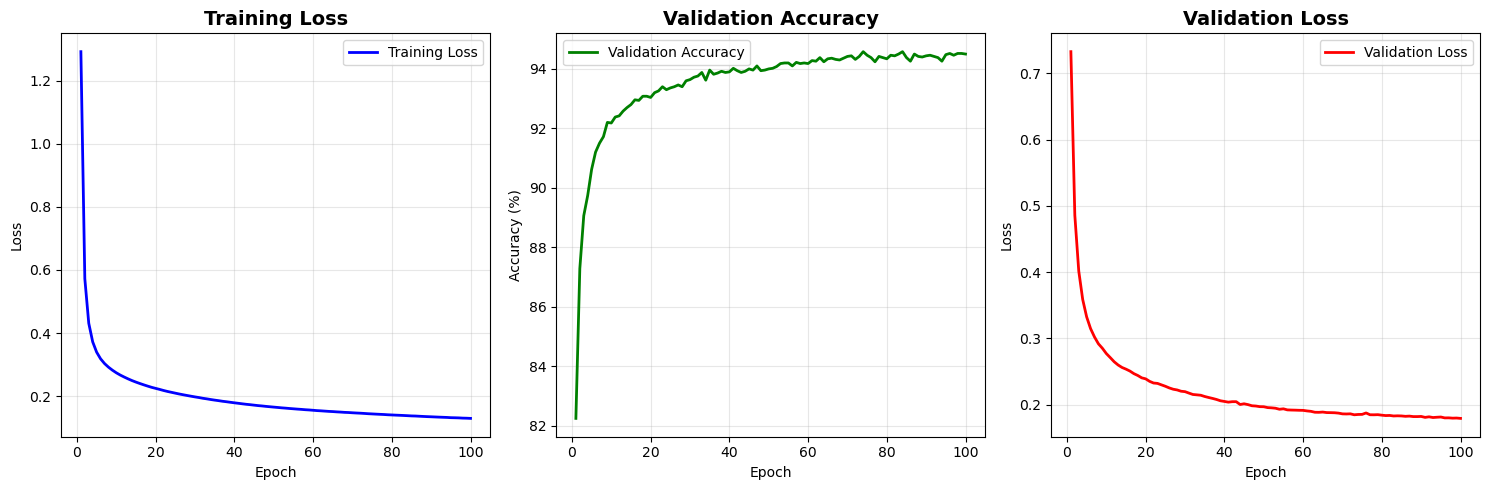

In [10]:
from sklearn.metrics import accuracy_score, classification_report
lr = 0.0001

hidden_size = 16

model_my_MLP = my_MLP(input_size, hidden_size, num_classes).to(device)
optimizer = torch.optim.Adam(model_my_MLP.parameters(), lr=lr)

run = wandb.init(
    project="DLALabs",
    name="lab1_esercizio1",
    config={
        "epochs": 100,
        "learning_rate": 0.0001,
        "batch_size": 128,
        "input_size": 28*28,
        "hidden_size": 16,
        "num_classes": 10,
        "optimizer": "Adam",
        "loss_function": "CrossEntropyLoss"
    }
)
run.watch(model_my_MLP, log="gradients", log_freq=1)
train_losses, val_accuracies, val_losses = train(model_my_MLP, dl_train, dl_val, epochs, criterion, optimizer, device)

plot_training_metrics(train_losses=train_losses,val_accuracies=val_accuracies, val_losses=val_losses)

In [11]:
wandb.init()
(accuracy, _, report) = evaluate(model_my_MLP, dl_test, device, log_wandb=True)

print(f'Test Accuracy: {accuracy:.2f}%')
print(f'\nClassification Report:\n{report}')
wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇████████████████████
val_loss,█▆▅▅▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,0.12939
val_accuracy,94.5
val_loss,0.17941


Test Accuracy: 95.22%

Classification Report:
              precision    recall  f1-score   support

           0      0.961     0.977     0.969       980
           1      0.976     0.982     0.979      1135
           2      0.961     0.948     0.954      1032
           3      0.941     0.947     0.944      1010
           4      0.952     0.949     0.951       982
           5      0.947     0.943     0.945       892
           6      0.948     0.965     0.956       958
           7      0.947     0.956     0.952      1028
           8      0.939     0.925     0.932       974
           9      0.946     0.927     0.936      1009

    accuracy                          0.952     10000
   macro avg      0.952     0.952     0.952     10000
weighted avg      0.952     0.952     0.952     10000



classification_report,precis...


### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

In [12]:
# Your code here.
class My_Configurable_MLP(nn.Module):
    def __init__(self, input_size, hidden_layers_sizes, num_classes):
        super(My_Configurable_MLP, self).__init__()
        layers = []
        layer_input_size = input_size

        for layer_size in hidden_layers_sizes:
            layers.append(nn.Linear(layer_input_size, layer_size))
            layers.append(nn.ReLU())
            layer_input_size = layer_size
        layers.append(nn.Linear(layer_input_size, num_classes))
        self.network = nn.Sequential(*layers) # create the network

    def forward(self, x):
        x = x.flatten(1)
        return self.network(x)

class Residual_MLP(nn.Module):
    def __init__(self, input_size, hidden_layers_sizes, num_classes):
        super(Residual_MLP, self).__init__()

        if isinstance(hidden_layers_sizes, int):
            hidden_layers_sizes = [hidden_layers_sizes] * 2
        
        self.fc_input = nn.Linear(input_size, hidden_layers_sizes[0])
        self.residual_blocks = nn.ModuleList()
        self.projections = nn.ModuleList()

        layer_input_size = hidden_layers_sizes[0]
        for layer_size in hidden_layers_sizes[1:]:
            self.residual_blocks.append(nn.Linear(layer_input_size, layer_size))
            if layer_input_size != layer_size:
                self.projections.append(nn.Linear(layer_input_size, layer_size))
            else:
                self.projections.append(None)
            layer_input_size = layer_size
        
        self.fc_output = nn.Linear(hidden_layers_sizes[-1], num_classes)

    def forward(self, x):
        x = x.flatten(1)
        x = F.relu(self.fc_input(x))

        for residual_layer, projection in zip(self.residual_blocks, self.projections):
            residual = x
            x = F.relu(residual_layer(x))
            if projection is not None:
                residual = projection(residual)
            x = x + residual
        x=self.fc_output(x)
        
    
        return x

In [13]:
from sklearn.metrics import accuracy_score, classification_report
width = 16
lr = 0.0001
depth_values = [1, 3, 5, 8, 16, 24, 32, 50] #3,

Epoch 0: Train Loss: 1.4483, Val Acc: 82.12%
Epoch 1: Train Loss: 0.6134, Val Acc: 86.94%
Epoch 2: Train Loss: 0.4495, Val Acc: 88.58%
Epoch 3: Train Loss: 0.3867, Val Acc: 89.60%
Epoch 4: Train Loss: 0.3517, Val Acc: 90.18%
Epoch 5: Train Loss: 0.3291, Val Acc: 90.80%
Epoch 6: Train Loss: 0.3129, Val Acc: 91.14%
Epoch 7: Train Loss: 0.3008, Val Acc: 91.26%
Epoch 8: Train Loss: 0.2909, Val Acc: 91.54%
Epoch 9: Train Loss: 0.2831, Val Acc: 91.92%
Epoch 10: Train Loss: 0.2761, Val Acc: 91.96%
Epoch 11: Train Loss: 0.2700, Val Acc: 92.22%
Epoch 12: Train Loss: 0.2646, Val Acc: 92.34%
Epoch 13: Train Loss: 0.2599, Val Acc: 92.54%
Epoch 14: Train Loss: 0.2556, Val Acc: 92.52%
Epoch 15: Train Loss: 0.2513, Val Acc: 92.60%
Epoch 16: Train Loss: 0.2474, Val Acc: 92.78%
Epoch 17: Train Loss: 0.2437, Val Acc: 92.90%
Epoch 18: Train Loss: 0.2397, Val Acc: 92.96%
Epoch 19: Train Loss: 0.2364, Val Acc: 92.98%
Epoch 20: Train Loss: 0.2330, Val Acc: 93.06%
Epoch 21: Train Loss: 0.2298, Val Acc: 93.16

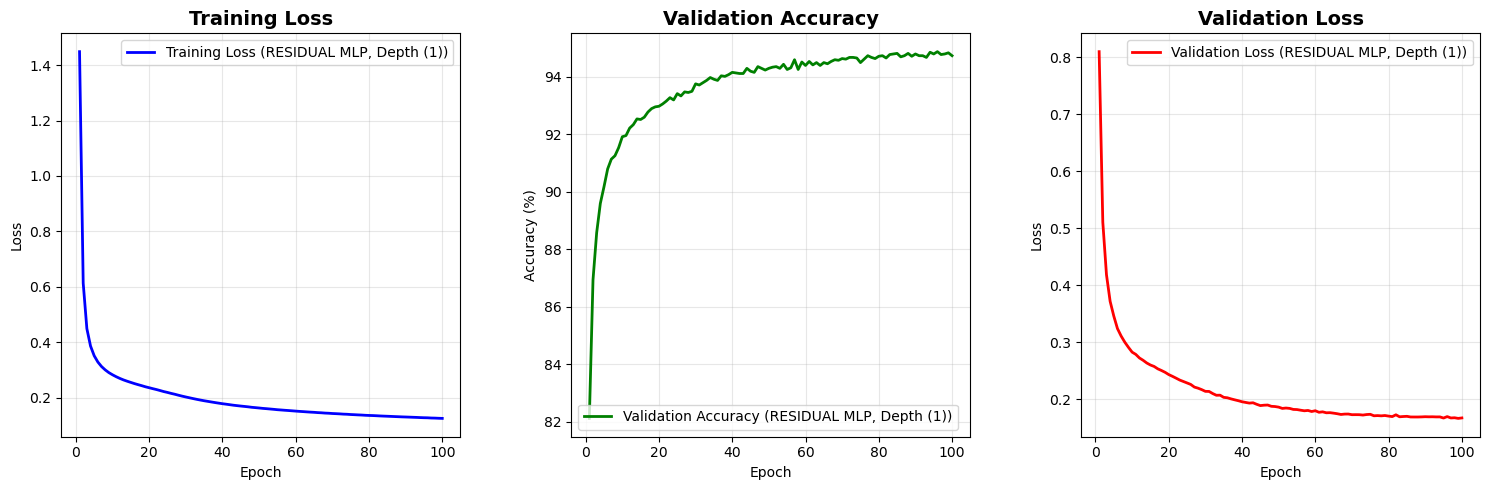

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 95.22%

Classification Report:
              precision    recall  f1-score   support

           0      0.965     0.986     0.975       980
           1      0.975     0.987     0.981      1135
           2      0.952     0.943     0.947      1032
           3      0.939     0.933     0.936      1010
           4      0.954     0.958     0.956       982
           5      0.930     0.938     0.934       892
           6      0.964     0.960     0.962       958
           7      0.960     0.949     0.955      1028
           8      0.926     0.921     0.923       974
           9      0.951     0.942     0.946      1009

    accuracy                          0.952     10000
   macro avg      0.952     0.952     0.952     10000
weighted avg      0.952     0.952     0.952     10000



epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▆▇▇▇▇▇▇▇▇▇▇██▇██████████████████████
val_loss,█▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,0.12584
val_accuracy,94.74
val_loss,0.16752


Epoch 0: Train Loss: 1.4197, Val Acc: 80.30%
Epoch 1: Train Loss: 0.5743, Val Acc: 86.94%
Epoch 2: Train Loss: 0.4048, Val Acc: 89.04%
Epoch 3: Train Loss: 0.3443, Val Acc: 90.10%
Epoch 4: Train Loss: 0.3121, Val Acc: 90.76%
Epoch 5: Train Loss: 0.2906, Val Acc: 91.26%
Epoch 6: Train Loss: 0.2739, Val Acc: 91.96%
Epoch 7: Train Loss: 0.2607, Val Acc: 92.34%
Epoch 8: Train Loss: 0.2491, Val Acc: 92.56%
Epoch 9: Train Loss: 0.2392, Val Acc: 92.60%
Epoch 10: Train Loss: 0.2310, Val Acc: 93.00%
Epoch 11: Train Loss: 0.2234, Val Acc: 93.26%
Epoch 12: Train Loss: 0.2164, Val Acc: 93.44%
Epoch 13: Train Loss: 0.2106, Val Acc: 93.60%
Epoch 14: Train Loss: 0.2047, Val Acc: 93.90%
Epoch 15: Train Loss: 0.2003, Val Acc: 94.16%
Epoch 16: Train Loss: 0.1960, Val Acc: 94.00%
Epoch 17: Train Loss: 0.1918, Val Acc: 94.22%
Epoch 18: Train Loss: 0.1882, Val Acc: 94.20%
Epoch 19: Train Loss: 0.1846, Val Acc: 94.08%
Epoch 20: Train Loss: 0.1812, Val Acc: 94.30%
Epoch 21: Train Loss: 0.1779, Val Acc: 94.34

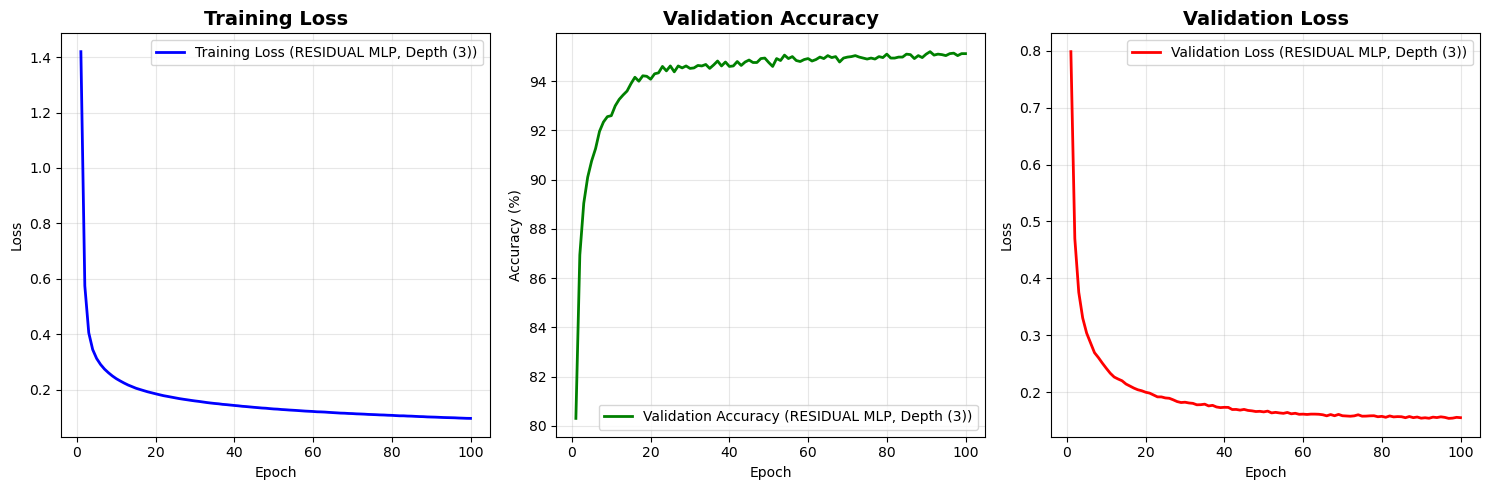

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 95.76%

Classification Report:
              precision    recall  f1-score   support

           0      0.969     0.981     0.975       980
           1      0.977     0.983     0.980      1135
           2      0.956     0.953     0.955      1032
           3      0.951     0.953     0.952      1010
           4      0.956     0.962     0.959       982
           5      0.947     0.941     0.944       892
           6      0.955     0.975     0.965       958
           7      0.964     0.961     0.962      1028
           8      0.949     0.927     0.938       974
           9      0.949     0.935     0.942      1009

    accuracy                          0.958     10000
   macro avg      0.957     0.957     0.957     10000
weighted avg      0.958     0.958     0.958     10000



epoch,▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇██▇███████████████████████████████
val_loss,█▇▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,0.09593
val_accuracy,95.12
val_loss,0.15487


Epoch 0: Train Loss: 1.3899, Val Acc: 81.38%
Epoch 1: Train Loss: 0.5228, Val Acc: 87.32%
Epoch 2: Train Loss: 0.3837, Val Acc: 89.36%
Epoch 3: Train Loss: 0.3357, Val Acc: 90.26%
Epoch 4: Train Loss: 0.3080, Val Acc: 90.96%
Epoch 5: Train Loss: 0.2876, Val Acc: 91.24%
Epoch 6: Train Loss: 0.2712, Val Acc: 92.04%
Epoch 7: Train Loss: 0.2572, Val Acc: 92.48%
Epoch 8: Train Loss: 0.2448, Val Acc: 92.96%
Epoch 9: Train Loss: 0.2335, Val Acc: 92.88%
Epoch 10: Train Loss: 0.2235, Val Acc: 93.40%
Epoch 11: Train Loss: 0.2143, Val Acc: 93.64%
Epoch 12: Train Loss: 0.2071, Val Acc: 93.58%
Epoch 13: Train Loss: 0.1997, Val Acc: 93.92%
Epoch 14: Train Loss: 0.1936, Val Acc: 93.96%
Epoch 15: Train Loss: 0.1879, Val Acc: 94.40%
Epoch 16: Train Loss: 0.1827, Val Acc: 94.14%
Epoch 17: Train Loss: 0.1787, Val Acc: 94.50%
Epoch 18: Train Loss: 0.1745, Val Acc: 94.56%
Epoch 19: Train Loss: 0.1708, Val Acc: 94.38%
Epoch 20: Train Loss: 0.1674, Val Acc: 94.86%
Epoch 21: Train Loss: 0.1643, Val Acc: 94.64

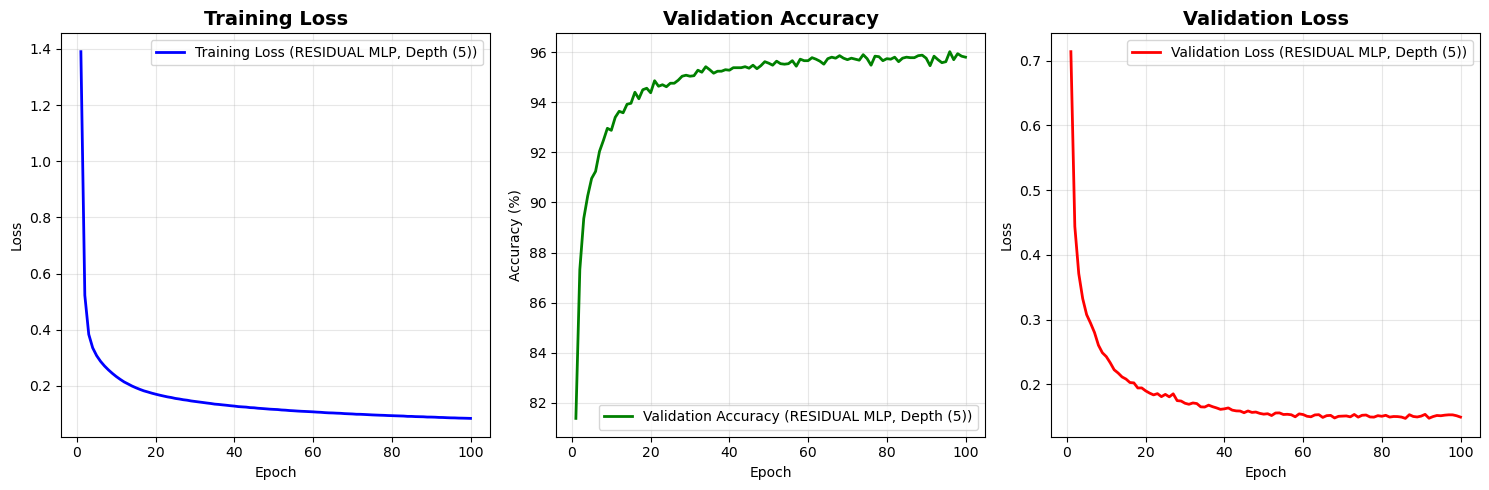

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 95.55%

Classification Report:
              precision    recall  f1-score   support

           0      0.966     0.985     0.975       980
           1      0.978     0.984     0.981      1135
           2      0.958     0.948     0.953      1032
           3      0.937     0.938     0.937      1010
           4      0.962     0.963     0.963       982
           5      0.952     0.943     0.948       892
           6      0.959     0.974     0.966       958
           7      0.960     0.942     0.951      1028
           8      0.934     0.939     0.937       974
           9      0.945     0.937     0.941      1009

    accuracy                          0.956     10000
   macro avg      0.955     0.955     0.955     10000
weighted avg      0.955     0.956     0.955     10000



epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▇▇▇█████████████████████████████
val_loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,0.08466
val_accuracy,95.8
val_loss,0.14935


Epoch 0: Train Loss: 1.4784, Val Acc: 80.06%
Epoch 1: Train Loss: 0.5477, Val Acc: 87.36%
Epoch 2: Train Loss: 0.3962, Val Acc: 89.26%
Epoch 3: Train Loss: 0.3319, Val Acc: 90.58%
Epoch 4: Train Loss: 0.2943, Val Acc: 91.34%
Epoch 5: Train Loss: 0.2695, Val Acc: 91.58%
Epoch 6: Train Loss: 0.2507, Val Acc: 92.24%
Epoch 7: Train Loss: 0.2357, Val Acc: 92.86%
Epoch 8: Train Loss: 0.2242, Val Acc: 92.88%
Epoch 9: Train Loss: 0.2144, Val Acc: 93.32%
Epoch 10: Train Loss: 0.2068, Val Acc: 93.44%
Epoch 11: Train Loss: 0.1992, Val Acc: 93.58%
Epoch 12: Train Loss: 0.1930, Val Acc: 93.84%
Epoch 13: Train Loss: 0.1875, Val Acc: 93.92%
Epoch 14: Train Loss: 0.1829, Val Acc: 94.16%
Epoch 15: Train Loss: 0.1781, Val Acc: 94.24%
Epoch 16: Train Loss: 0.1748, Val Acc: 94.26%
Epoch 17: Train Loss: 0.1704, Val Acc: 94.34%
Epoch 18: Train Loss: 0.1672, Val Acc: 94.36%
Epoch 19: Train Loss: 0.1636, Val Acc: 94.48%
Epoch 20: Train Loss: 0.1603, Val Acc: 94.56%
Epoch 21: Train Loss: 0.1577, Val Acc: 94.84

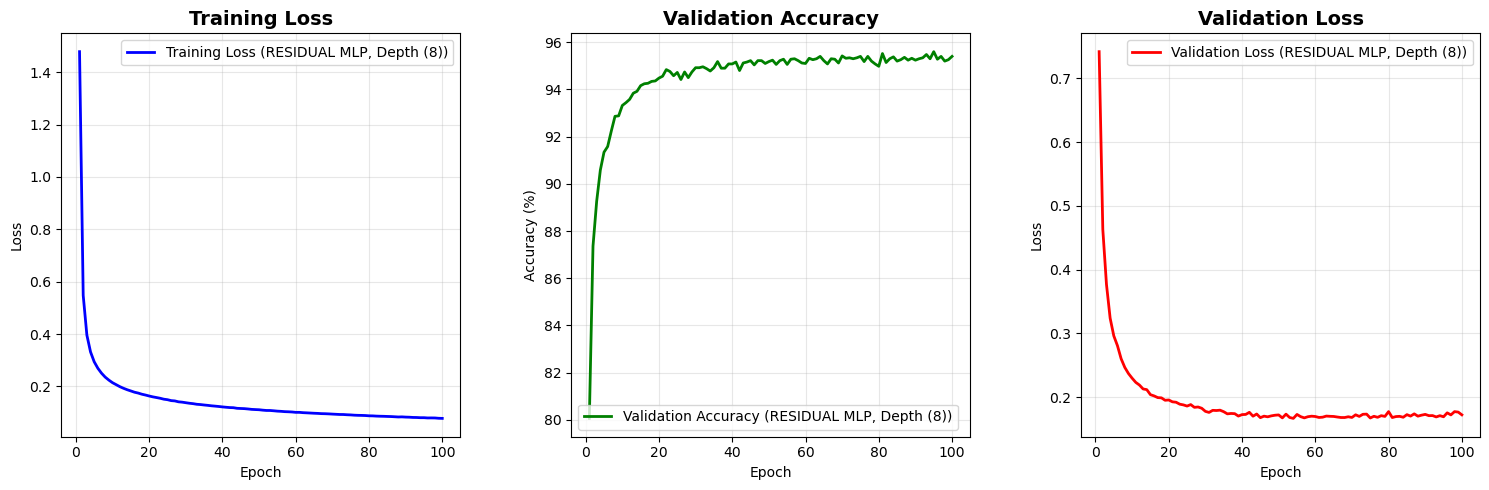

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 95.56%

Classification Report:
              precision    recall  f1-score   support

           0      0.972     0.973     0.973       980
           1      0.979     0.981     0.980      1135
           2      0.956     0.955     0.956      1032
           3      0.944     0.955     0.950      1010
           4      0.957     0.961     0.959       982
           5      0.948     0.945     0.947       892
           6      0.954     0.958     0.956       958
           7      0.959     0.947     0.953      1028
           8      0.934     0.943     0.938       974
           9      0.948     0.932     0.940      1009

    accuracy                          0.956     10000
   macro avg      0.955     0.955     0.955     10000
weighted avg      0.956     0.956     0.956     10000



epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇██████████████████████████████████
val_loss,██▆▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,0.07809
val_accuracy,95.4
val_loss,0.17239


Epoch 0: Train Loss: 2.0062, Val Acc: 64.74%
Epoch 1: Train Loss: 0.7661, Val Acc: 83.64%
Epoch 2: Train Loss: 0.4535, Val Acc: 87.82%
Epoch 3: Train Loss: 0.3607, Val Acc: 90.12%
Epoch 4: Train Loss: 0.3120, Val Acc: 91.70%
Epoch 5: Train Loss: 0.2772, Val Acc: 92.20%
Epoch 6: Train Loss: 0.2533, Val Acc: 92.96%
Epoch 7: Train Loss: 0.2343, Val Acc: 93.14%
Epoch 8: Train Loss: 0.2200, Val Acc: 93.48%
Epoch 9: Train Loss: 0.2095, Val Acc: 94.06%
Epoch 10: Train Loss: 0.1985, Val Acc: 93.78%
Epoch 11: Train Loss: 0.1909, Val Acc: 94.06%
Epoch 12: Train Loss: 0.1847, Val Acc: 94.04%
Epoch 13: Train Loss: 0.1780, Val Acc: 94.20%
Epoch 14: Train Loss: 0.1730, Val Acc: 94.26%
Epoch 15: Train Loss: 0.1674, Val Acc: 94.20%
Epoch 16: Train Loss: 0.1631, Val Acc: 94.78%
Epoch 17: Train Loss: 0.1590, Val Acc: 94.54%
Epoch 18: Train Loss: 0.1549, Val Acc: 94.52%
Epoch 19: Train Loss: 0.1515, Val Acc: 94.48%
Epoch 20: Train Loss: 0.1483, Val Acc: 94.58%
Epoch 21: Train Loss: 0.1455, Val Acc: 94.38

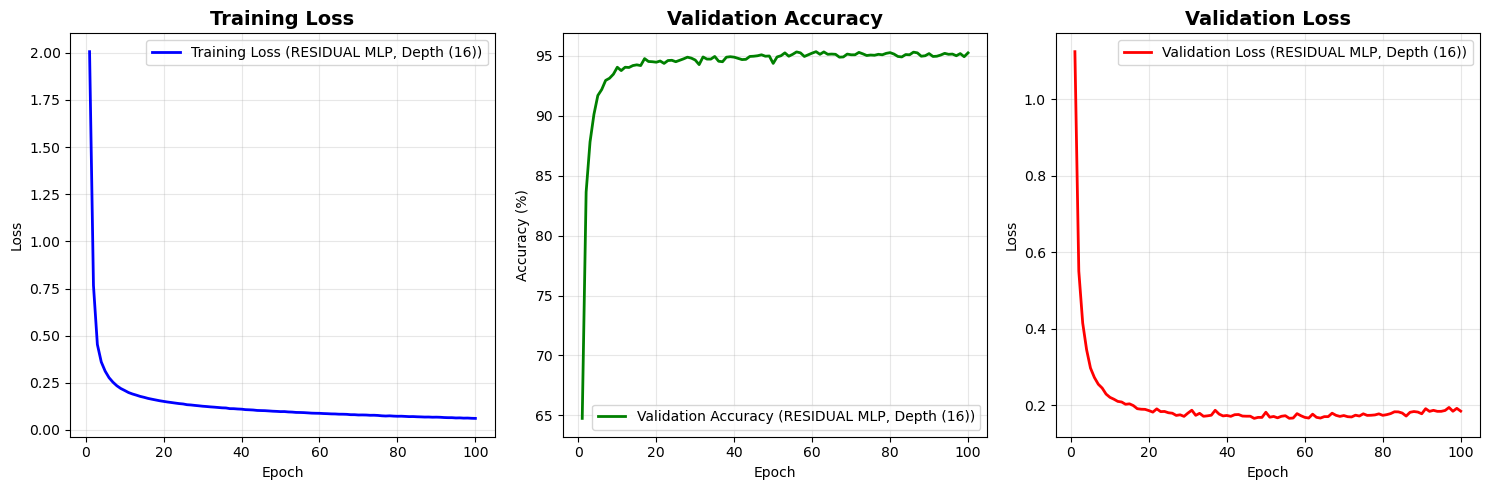

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 95.18%

Classification Report:
              precision    recall  f1-score   support

           0      0.967     0.984     0.975       980
           1      0.976     0.982     0.979      1135
           2      0.934     0.946     0.940      1032
           3      0.934     0.946     0.940      1010
           4      0.954     0.959     0.957       982
           5      0.942     0.924     0.933       892
           6      0.958     0.961     0.960       958
           7      0.969     0.938     0.953      1028
           8      0.925     0.945     0.934       974
           9      0.956     0.929     0.942      1009

    accuracy                          0.952     10000
   macro avg      0.951     0.951     0.951     10000
weighted avg      0.952     0.952     0.952     10000



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▅▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇▇█▇██████████████████████████████
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,0.06139
val_accuracy,95.26
val_loss,0.18493


Epoch 0: Train Loss: 9.4719, Val Acc: 9.58%
Epoch 1: Train Loss: 2.6795, Val Acc: 9.58%
Epoch 2: Train Loss: 2.3648, Val Acc: 9.60%
Epoch 3: Train Loss: 2.2532, Val Acc: 21.32%
Epoch 4: Train Loss: 2.0459, Val Acc: 30.96%
Epoch 5: Train Loss: 1.6114, Val Acc: 53.88%
Epoch 6: Train Loss: 1.0462, Val Acc: 67.82%
Epoch 7: Train Loss: 0.8416, Val Acc: 75.12%
Epoch 8: Train Loss: 0.6885, Val Acc: 80.46%
Epoch 9: Train Loss: 0.5881, Val Acc: 82.74%
Epoch 10: Train Loss: 0.5251, Val Acc: 84.84%
Epoch 11: Train Loss: 0.4736, Val Acc: 86.04%
Epoch 12: Train Loss: 0.4265, Val Acc: 87.30%
Epoch 13: Train Loss: 0.3906, Val Acc: 88.56%
Epoch 14: Train Loss: 0.3583, Val Acc: 89.30%
Epoch 15: Train Loss: 0.3328, Val Acc: 89.54%
Epoch 16: Train Loss: 0.3135, Val Acc: 89.92%
Epoch 17: Train Loss: 0.2923, Val Acc: 90.38%
Epoch 18: Train Loss: 0.2806, Val Acc: 90.32%
Epoch 19: Train Loss: 0.2634, Val Acc: 91.54%
Epoch 20: Train Loss: 0.2459, Val Acc: 91.78%
Epoch 21: Train Loss: 0.2320, Val Acc: 92.56%
E

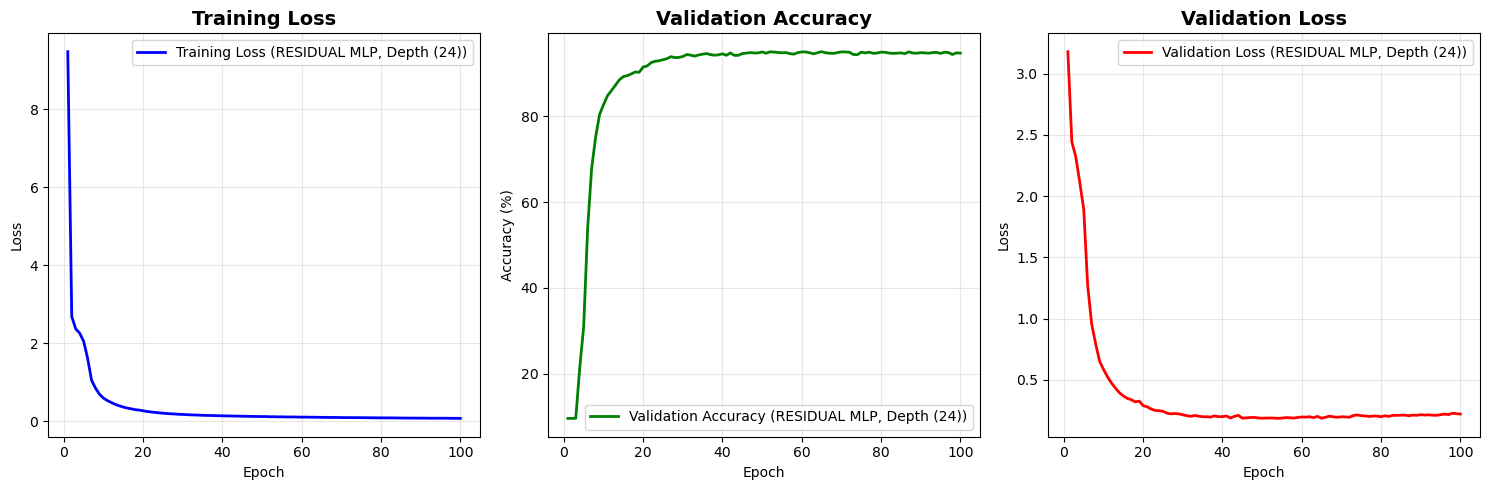

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 95.05%

Classification Report:
              precision    recall  f1-score   support

           0      0.963     0.968     0.966       980
           1      0.980     0.988     0.984      1135
           2      0.963     0.940     0.951      1032
           3      0.939     0.950     0.945      1010
           4      0.960     0.946     0.953       982
           5      0.958     0.904     0.930       892
           6      0.949     0.971     0.960       958
           7      0.953     0.936     0.945      1028
           8      0.904     0.959     0.931       974
           9      0.934     0.936     0.935      1009

    accuracy                          0.951     10000
   macro avg      0.950     0.950     0.950     10000
weighted avg      0.951     0.951     0.950     10000



epoch,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇▇▇███████████████████████████████████
val_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,0.06838
val_accuracy,94.78
val_loss,0.22


Epoch 0: Train Loss: 41.4045, Val Acc: 10.88%
Epoch 1: Train Loss: 4.6940, Val Acc: 10.88%
Epoch 2: Train Loss: 2.9260, Val Acc: 15.20%
Epoch 3: Train Loss: 2.2946, Val Acc: 25.76%
Epoch 4: Train Loss: 1.9799, Val Acc: 27.46%
Epoch 5: Train Loss: 1.8761, Val Acc: 30.62%
Epoch 6: Train Loss: 1.7557, Val Acc: 42.44%
Epoch 7: Train Loss: 1.4544, Val Acc: 57.22%
Epoch 8: Train Loss: 1.1567, Val Acc: 62.84%
Epoch 9: Train Loss: 0.9692, Val Acc: 70.38%
Epoch 10: Train Loss: 0.8125, Val Acc: 75.54%
Epoch 11: Train Loss: 0.6933, Val Acc: 79.60%
Epoch 12: Train Loss: 0.6004, Val Acc: 83.26%
Epoch 13: Train Loss: 0.5332, Val Acc: 84.92%
Epoch 14: Train Loss: 0.4878, Val Acc: 85.52%
Epoch 15: Train Loss: 0.4520, Val Acc: 86.76%
Epoch 16: Train Loss: 0.4230, Val Acc: 87.92%
Epoch 17: Train Loss: 0.3922, Val Acc: 88.04%
Epoch 18: Train Loss: 0.3648, Val Acc: 88.90%
Epoch 19: Train Loss: 0.3380, Val Acc: 89.02%
Epoch 20: Train Loss: 0.3132, Val Acc: 90.02%
Epoch 21: Train Loss: 0.2920, Val Acc: 90.4

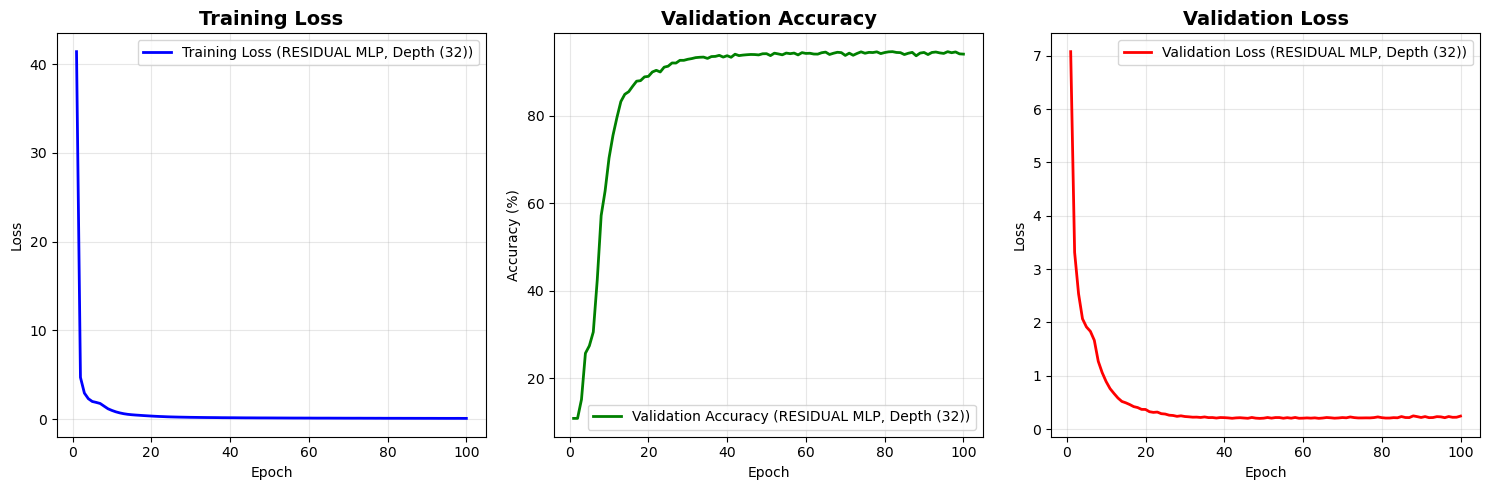

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 94.60%

Classification Report:
              precision    recall  f1-score   support

           0      0.970     0.977     0.973       980
           1      0.977     0.991     0.984      1135
           2      0.957     0.943     0.950      1032
           3      0.912     0.941     0.926      1010
           4      0.949     0.932     0.940       982
           5      0.927     0.943     0.935       892
           6      0.969     0.951     0.960       958
           7      0.921     0.968     0.944      1028
           8      0.961     0.885     0.921       974
           9      0.918     0.923     0.920      1009

    accuracy                          0.946     10000
   macro avg      0.946     0.945     0.945     10000
weighted avg      0.946     0.946     0.946     10000



epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▃▅▆▇▇▇▇██████████████████████████████
val_loss,███▇▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,0.07512
val_accuracy,94.1
val_loss,0.24446


Epoch 0: Train Loss: 1202.9475, Val Acc: 10.52%
Epoch 1: Train Loss: 79.2176, Val Acc: 12.06%
Epoch 2: Train Loss: 15.0994, Val Acc: 9.16%
Epoch 3: Train Loss: 2.5994, Val Acc: 12.74%
Epoch 4: Train Loss: 2.3085, Val Acc: 11.30%
Epoch 5: Train Loss: 2.2999, Val Acc: 13.82%
Epoch 6: Train Loss: 2.2919, Val Acc: 14.22%
Epoch 7: Train Loss: 2.2831, Val Acc: 15.38%
Epoch 8: Train Loss: 2.2675, Val Acc: 15.80%
Epoch 9: Train Loss: 2.2540, Val Acc: 15.46%
Epoch 10: Train Loss: 2.2354, Val Acc: 16.68%
Epoch 11: Train Loss: 2.2101, Val Acc: 18.34%
Epoch 12: Train Loss: 2.1819, Val Acc: 20.58%
Epoch 13: Train Loss: 2.0677, Val Acc: 31.90%
Epoch 14: Train Loss: 1.8012, Val Acc: 38.66%
Epoch 15: Train Loss: 1.6154, Val Acc: 43.56%
Epoch 16: Train Loss: 1.4560, Val Acc: 50.58%
Epoch 17: Train Loss: 1.3282, Val Acc: 57.28%
Epoch 18: Train Loss: 1.2077, Val Acc: 59.44%
Epoch 19: Train Loss: 1.1202, Val Acc: 61.54%
Epoch 20: Train Loss: 1.0764, Val Acc: 59.76%
Epoch 21: Train Loss: 1.0260, Val Acc: 6

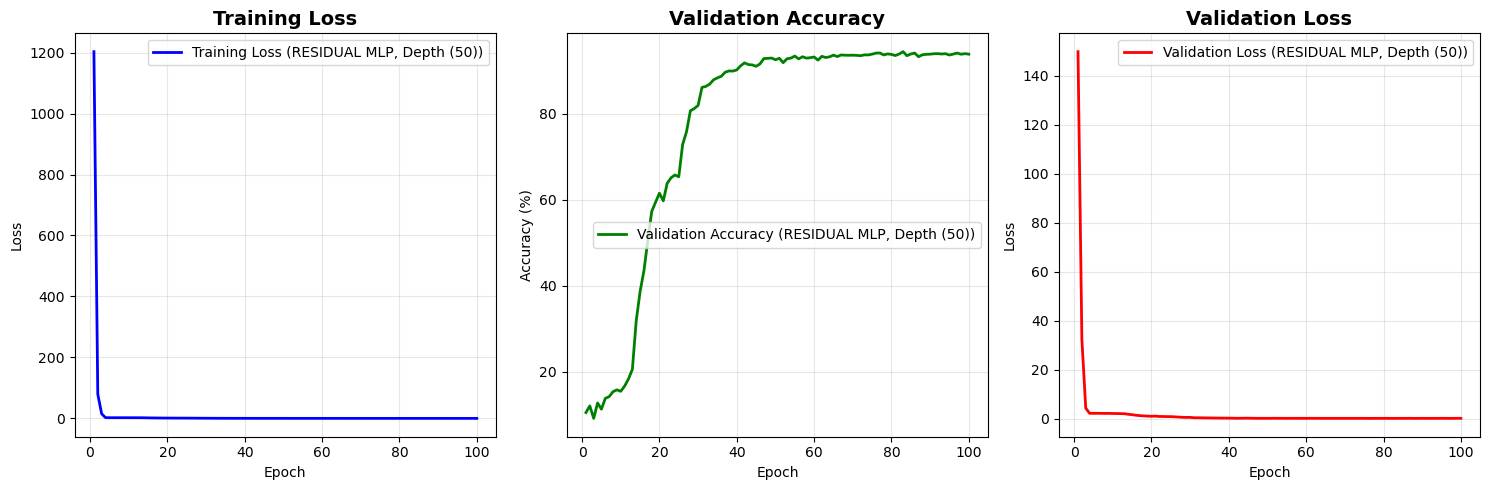

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 94.45%

Classification Report:
              precision    recall  f1-score   support

           0      0.962     0.976     0.969       980
           1      0.987     0.982     0.985      1135
           2      0.955     0.930     0.943      1032
           3      0.896     0.943     0.919      1010
           4      0.940     0.942     0.941       982
           5      0.967     0.873     0.918       892
           6      0.943     0.974     0.958       958
           7      0.964     0.936     0.950      1028
           8      0.923     0.941     0.932       974
           9      0.911     0.938     0.924      1009

    accuracy                          0.945     10000
   macro avg      0.945     0.943     0.944     10000
weighted avg      0.945     0.945     0.944     10000



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▂▃▅▆▆▇▇▇█████████████████████████████
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,0.10217
val_accuracy,93.88
val_loss,0.27242


In [14]:
for depth in depth_values:
    name_run = "lab1_esercizio1.2_Residual_MLP - depth: " + str(depth)
    model_residual_MLP = Residual_MLP(input_size, [width]*depth, num_classes).to(device)
    optimizer = torch.optim.Adam(model_residual_MLP.parameters(), lr=lr)
    run = wandb.init(
        project="DLALabs",
        name=name_run,
        config={
            "model": "Residual-MLP",
            "epochs": 100,
            "learning_rate": 0.0001,
            "batch_size": 128,
            "input_size": 28*28,
            "width": width,
            "depth": depth,
            "num_classes": 10,
            "optimizer": "Adam",
            "loss_function": "CrossEntropyLoss"
        }
    )
    run.watch(model_residual_MLP, log="gradients", log_freq=1)
    train_losses, val_accuracies, val_losses = train(model_residual_MLP, dl_train, dl_val, epochs, criterion, optimizer, device)
    print("RESIDUAL MLP")
    plot_training_metrics(train_losses=train_losses,val_accuracies=val_accuracies, val_losses=val_losses, save_path="plot", model_name="RESIDUAL MLP", model_depth=depth)
    (accuracy, _, report) = evaluate(model_residual_MLP, dl_test, device, log_wandb=True)

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'\nClassification Report:\n{report}')
    wandb.finish()


Epoch 0: Train Loss: 1.3956, Val Acc: 82.50%
Epoch 1: Train Loss: 0.6181, Val Acc: 87.82%
Epoch 2: Train Loss: 0.4450, Val Acc: 89.32%
Epoch 3: Train Loss: 0.3773, Val Acc: 90.26%
Epoch 4: Train Loss: 0.3418, Val Acc: 90.82%
Epoch 5: Train Loss: 0.3192, Val Acc: 91.06%
Epoch 6: Train Loss: 0.3030, Val Acc: 91.34%
Epoch 7: Train Loss: 0.2907, Val Acc: 91.72%
Epoch 8: Train Loss: 0.2805, Val Acc: 92.04%
Epoch 9: Train Loss: 0.2720, Val Acc: 92.10%
Epoch 10: Train Loss: 0.2648, Val Acc: 92.38%
Epoch 11: Train Loss: 0.2584, Val Acc: 92.54%
Epoch 12: Train Loss: 0.2527, Val Acc: 92.62%
Epoch 13: Train Loss: 0.2476, Val Acc: 92.62%
Epoch 14: Train Loss: 0.2428, Val Acc: 92.84%
Epoch 15: Train Loss: 0.2385, Val Acc: 93.14%
Epoch 16: Train Loss: 0.2346, Val Acc: 93.20%
Epoch 17: Train Loss: 0.2308, Val Acc: 93.14%
Epoch 18: Train Loss: 0.2273, Val Acc: 93.44%
Epoch 19: Train Loss: 0.2240, Val Acc: 93.44%
Epoch 20: Train Loss: 0.2210, Val Acc: 93.62%
Epoch 21: Train Loss: 0.2182, Val Acc: 93.86

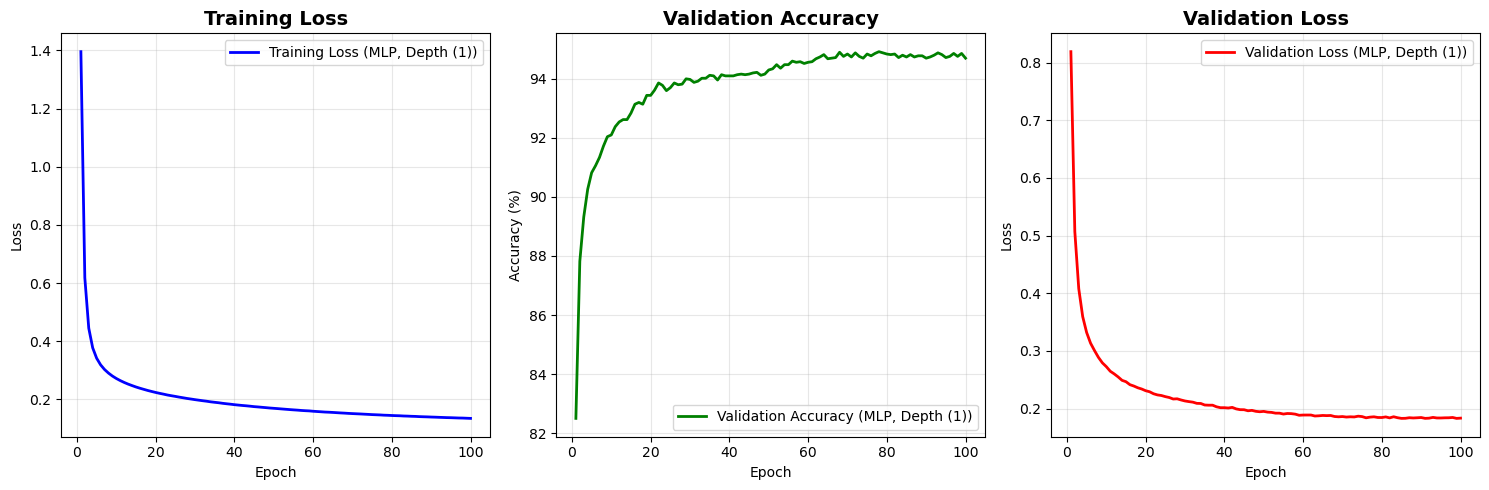

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 95.04%

Classification Report:
              precision    recall  f1-score   support

           0      0.964     0.980     0.972       980
           1      0.979     0.985     0.982      1135
           2      0.956     0.946     0.951      1032
           3      0.934     0.941     0.937      1010
           4      0.944     0.955     0.949       982
           5      0.936     0.930     0.933       892
           6      0.955     0.960     0.958       958
           7      0.952     0.954     0.953      1028
           8      0.942     0.922     0.932       974
           9      0.937     0.925     0.931      1009

    accuracy                          0.950     10000
   macro avg      0.950     0.950     0.950     10000
weighted avg      0.950     0.950     0.950     10000



epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇▇▇▇▇█▇▇███████████████████████████
val_loss,██▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,0.13484
val_accuracy,94.7
val_loss,0.1836


Epoch 0: Train Loss: 1.8944, Val Acc: 62.82%
Epoch 1: Train Loss: 0.9998, Val Acc: 79.14%
Epoch 2: Train Loss: 0.6333, Val Acc: 83.22%
Epoch 3: Train Loss: 0.5210, Val Acc: 85.42%
Epoch 4: Train Loss: 0.4630, Val Acc: 86.74%
Epoch 5: Train Loss: 0.4241, Val Acc: 87.60%
Epoch 6: Train Loss: 0.3948, Val Acc: 88.30%
Epoch 7: Train Loss: 0.3722, Val Acc: 88.94%
Epoch 8: Train Loss: 0.3542, Val Acc: 89.22%
Epoch 9: Train Loss: 0.3387, Val Acc: 89.68%
Epoch 10: Train Loss: 0.3251, Val Acc: 89.48%
Epoch 11: Train Loss: 0.3128, Val Acc: 90.10%
Epoch 12: Train Loss: 0.3019, Val Acc: 90.20%
Epoch 13: Train Loss: 0.2918, Val Acc: 90.68%
Epoch 14: Train Loss: 0.2824, Val Acc: 90.70%
Epoch 15: Train Loss: 0.2745, Val Acc: 91.10%
Epoch 16: Train Loss: 0.2670, Val Acc: 91.44%
Epoch 17: Train Loss: 0.2604, Val Acc: 91.56%
Epoch 18: Train Loss: 0.2543, Val Acc: 91.80%
Epoch 19: Train Loss: 0.2486, Val Acc: 91.88%
Epoch 20: Train Loss: 0.2433, Val Acc: 91.86%
Epoch 21: Train Loss: 0.2385, Val Acc: 92.28

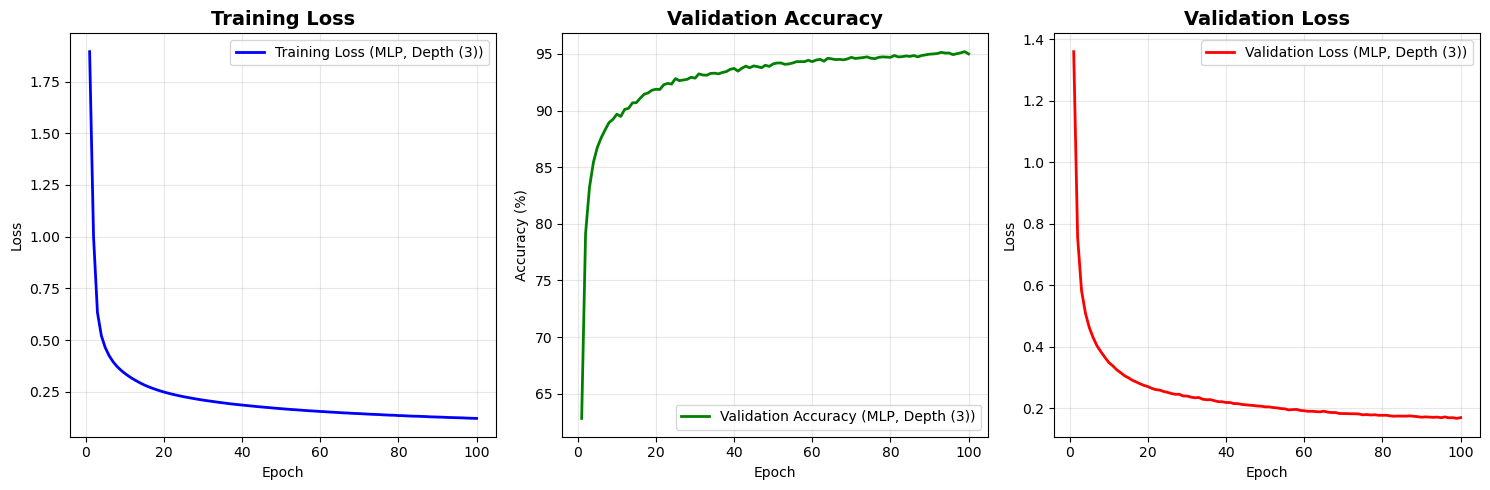

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 95.28%

Classification Report:
              precision    recall  f1-score   support

           0      0.953     0.974     0.964       980
           1      0.976     0.984     0.980      1135
           2      0.963     0.946     0.955      1032
           3      0.939     0.944     0.941      1010
           4      0.964     0.953     0.959       982
           5      0.935     0.941     0.938       892
           6      0.952     0.965     0.958       958
           7      0.955     0.947     0.951      1028
           8      0.936     0.928     0.932       974
           9      0.949     0.942     0.945      1009

    accuracy                          0.953     10000
   macro avg      0.952     0.952     0.952     10000
weighted avg      0.953     0.953     0.953     10000



epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇███████████████
val_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,0.12098
val_accuracy,95
val_loss,0.1693


Epoch 0: Train Loss: 2.1086, Val Acc: 29.12%
Epoch 1: Train Loss: 1.4623, Val Acc: 54.02%
Epoch 2: Train Loss: 1.1043, Val Acc: 63.62%
Epoch 3: Train Loss: 0.9514, Val Acc: 69.76%
Epoch 4: Train Loss: 0.8171, Val Acc: 76.16%
Epoch 5: Train Loss: 0.6820, Val Acc: 79.88%
Epoch 6: Train Loss: 0.5880, Val Acc: 82.52%
Epoch 7: Train Loss: 0.5282, Val Acc: 84.60%
Epoch 8: Train Loss: 0.4845, Val Acc: 85.78%
Epoch 9: Train Loss: 0.4504, Val Acc: 86.08%
Epoch 10: Train Loss: 0.4238, Val Acc: 87.10%
Epoch 11: Train Loss: 0.4018, Val Acc: 87.48%
Epoch 12: Train Loss: 0.3847, Val Acc: 87.96%
Epoch 13: Train Loss: 0.3704, Val Acc: 88.52%
Epoch 14: Train Loss: 0.3582, Val Acc: 88.84%
Epoch 15: Train Loss: 0.3478, Val Acc: 88.94%
Epoch 16: Train Loss: 0.3387, Val Acc: 89.42%
Epoch 17: Train Loss: 0.3307, Val Acc: 89.66%
Epoch 18: Train Loss: 0.3243, Val Acc: 89.92%
Epoch 19: Train Loss: 0.3182, Val Acc: 90.26%
Epoch 20: Train Loss: 0.3122, Val Acc: 90.20%
Epoch 21: Train Loss: 0.3071, Val Acc: 90.42

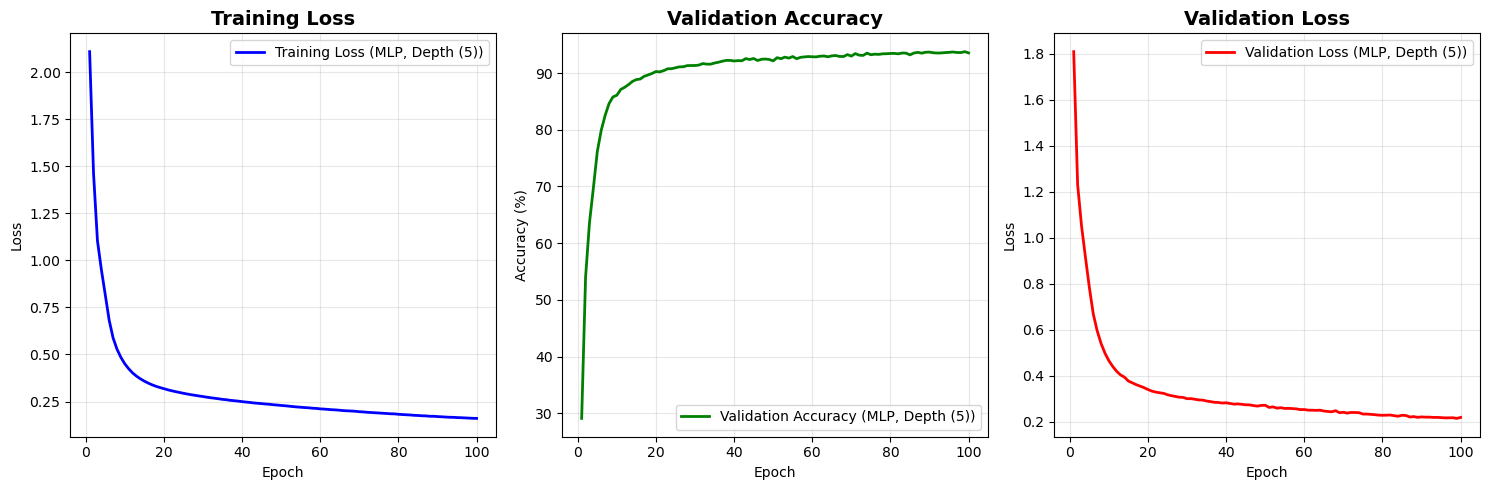

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 94.07%

Classification Report:
              precision    recall  f1-score   support

           0      0.952     0.973     0.963       980
           1      0.976     0.977     0.977      1135
           2      0.960     0.946     0.953      1032
           3      0.919     0.917     0.918      1010
           4      0.944     0.931     0.937       982
           5      0.896     0.907     0.901       892
           6      0.951     0.968     0.959       958
           7      0.953     0.933     0.943      1028
           8      0.941     0.915     0.928       974
           9      0.908     0.934     0.920      1009

    accuracy                          0.941     10000
   macro avg      0.940     0.940     0.940     10000
weighted avg      0.941     0.941     0.941     10000



epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇█████████████████████████
val_loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,0.16044
val_accuracy,93.54
val_loss,0.21894


Epoch 0: Train Loss: 2.2826, Val Acc: 23.86%
Epoch 1: Train Loss: 1.8203, Val Acc: 43.42%
Epoch 2: Train Loss: 1.2584, Val Acc: 59.10%
Epoch 3: Train Loss: 0.9704, Val Acc: 68.52%
Epoch 4: Train Loss: 0.8527, Val Acc: 71.66%
Epoch 5: Train Loss: 0.7858, Val Acc: 74.28%
Epoch 6: Train Loss: 0.7426, Val Acc: 75.72%
Epoch 7: Train Loss: 0.7095, Val Acc: 76.72%
Epoch 8: Train Loss: 0.6810, Val Acc: 77.92%
Epoch 9: Train Loss: 0.6559, Val Acc: 79.46%
Epoch 10: Train Loss: 0.6332, Val Acc: 80.26%
Epoch 11: Train Loss: 0.6128, Val Acc: 80.98%
Epoch 12: Train Loss: 0.5942, Val Acc: 81.10%
Epoch 13: Train Loss: 0.5757, Val Acc: 81.76%
Epoch 14: Train Loss: 0.5600, Val Acc: 82.22%
Epoch 15: Train Loss: 0.5440, Val Acc: 82.68%
Epoch 16: Train Loss: 0.5301, Val Acc: 83.04%
Epoch 17: Train Loss: 0.5164, Val Acc: 83.58%
Epoch 18: Train Loss: 0.5034, Val Acc: 84.02%
Epoch 19: Train Loss: 0.4918, Val Acc: 84.78%
Epoch 20: Train Loss: 0.4813, Val Acc: 84.66%
Epoch 21: Train Loss: 0.4725, Val Acc: 84.68

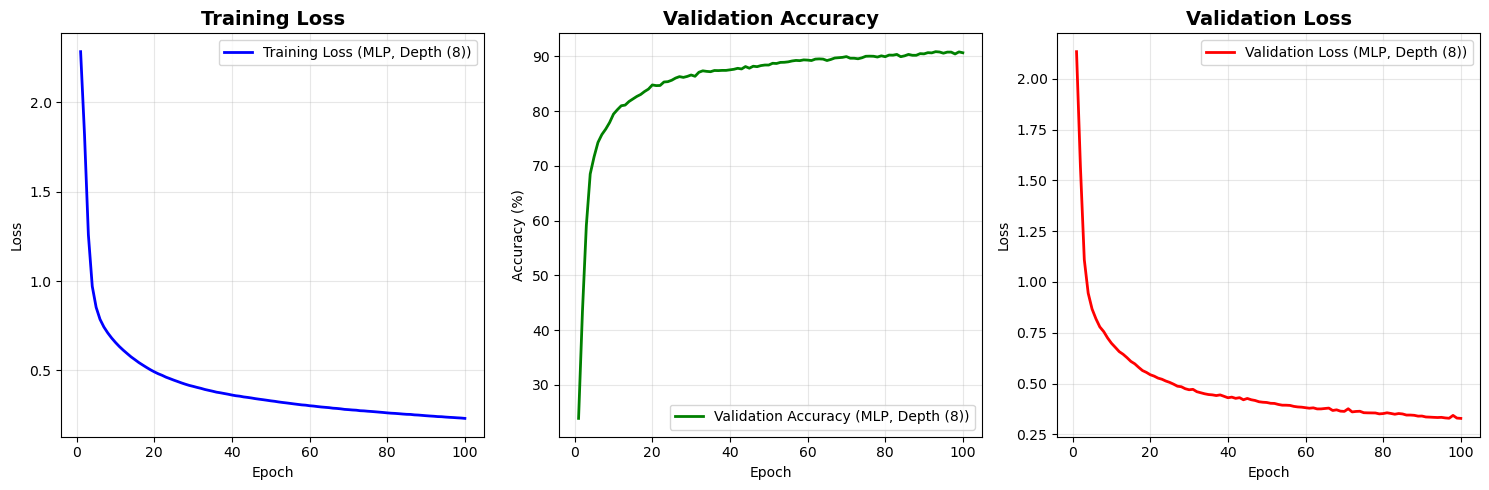

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 92.21%

Classification Report:
              precision    recall  f1-score   support

           0      0.950     0.979     0.964       980
           1      0.948     0.974     0.961      1135
           2      0.945     0.896     0.920      1032
           3      0.896     0.906     0.901      1010
           4      0.936     0.933     0.934       982
           5      0.859     0.885     0.871       892
           6      0.936     0.947     0.941       958
           7      0.960     0.917     0.938      1028
           8      0.862     0.883     0.872       974
           9      0.921     0.894     0.907      1009

    accuracy                          0.922     10000
   macro avg      0.921     0.921     0.921     10000
weighted avg      0.923     0.922     0.922     10000



epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▃▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████
val_loss,█▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,0.23167
val_accuracy,90.66
val_loss,0.32862


Epoch 0: Train Loss: 2.3063, Val Acc: 11.60%
Epoch 1: Train Loss: 2.1483, Val Acc: 23.92%
Epoch 2: Train Loss: 1.7581, Val Acc: 37.64%
Epoch 3: Train Loss: 1.4673, Val Acc: 45.42%
Epoch 4: Train Loss: 1.3248, Val Acc: 49.54%
Epoch 5: Train Loss: 1.2496, Val Acc: 52.26%
Epoch 6: Train Loss: 1.1865, Val Acc: 55.50%
Epoch 7: Train Loss: 1.1296, Val Acc: 57.36%
Epoch 8: Train Loss: 1.0869, Val Acc: 58.80%
Epoch 9: Train Loss: 1.0520, Val Acc: 60.18%
Epoch 10: Train Loss: 1.0261, Val Acc: 61.94%
Epoch 11: Train Loss: 1.0012, Val Acc: 62.78%
Epoch 12: Train Loss: 0.9810, Val Acc: 61.00%
Epoch 13: Train Loss: 0.9652, Val Acc: 64.34%
Epoch 14: Train Loss: 0.9486, Val Acc: 64.36%
Epoch 15: Train Loss: 0.9356, Val Acc: 65.78%
Epoch 16: Train Loss: 0.9224, Val Acc: 66.38%
Epoch 17: Train Loss: 0.9115, Val Acc: 67.16%
Epoch 18: Train Loss: 0.8976, Val Acc: 66.88%
Epoch 19: Train Loss: 0.8876, Val Acc: 67.70%
Epoch 20: Train Loss: 0.8775, Val Acc: 68.72%
Epoch 21: Train Loss: 0.8681, Val Acc: 68.90

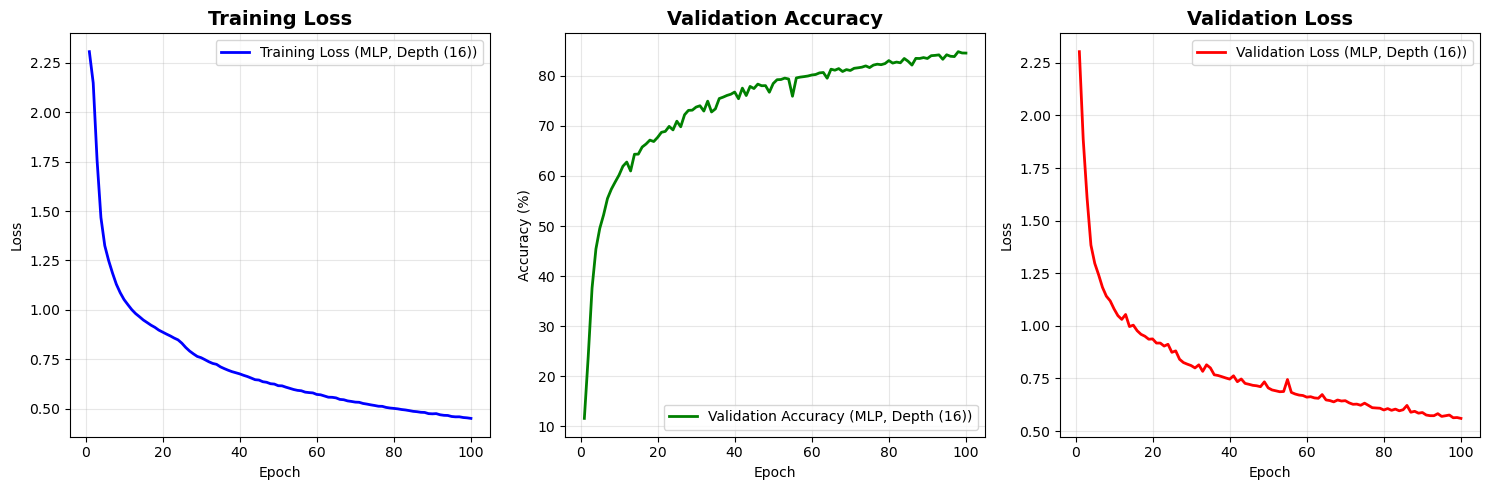

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 86.30%

Classification Report:
              precision    recall  f1-score   support

           0      0.883     0.924     0.903       980
           1      0.989     0.946     0.967      1135
           2      0.892     0.828     0.859      1032
           3      0.721     0.784     0.751      1010
           4      0.858     0.916     0.886       982
           5      0.781     0.828     0.804       892
           6      0.877     0.868     0.873       958
           7      0.954     0.877     0.914      1028
           8      0.787     0.776     0.782       974
           9      0.889     0.866     0.878      1009

    accuracy                          0.863     10000
   macro avg      0.863     0.862     0.862     10000
weighted avg      0.866     0.863     0.864     10000



epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████
val_loss,█▇▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,0.45081
val_accuracy,84.54
val_loss,0.56027


Epoch 0: Train Loss: 2.3149, Val Acc: 8.74%
Epoch 1: Train Loss: 2.2641, Val Acc: 21.26%
Epoch 2: Train Loss: 1.9582, Val Acc: 22.24%
Epoch 3: Train Loss: 1.8798, Val Acc: 22.24%
Epoch 4: Train Loss: 1.8120, Val Acc: 23.44%
Epoch 5: Train Loss: 1.7435, Val Acc: 28.56%
Epoch 6: Train Loss: 1.6690, Val Acc: 37.34%
Epoch 7: Train Loss: 1.5658, Val Acc: 40.96%
Epoch 8: Train Loss: 1.5077, Val Acc: 41.26%
Epoch 9: Train Loss: 1.4640, Val Acc: 43.20%
Epoch 10: Train Loss: 1.4166, Val Acc: 49.34%
Epoch 11: Train Loss: 1.3434, Val Acc: 53.24%
Epoch 12: Train Loss: 1.2520, Val Acc: 56.78%
Epoch 13: Train Loss: 1.1783, Val Acc: 56.68%
Epoch 14: Train Loss: 1.1281, Val Acc: 59.84%
Epoch 15: Train Loss: 1.0921, Val Acc: 60.16%
Epoch 16: Train Loss: 1.0631, Val Acc: 61.50%
Epoch 17: Train Loss: 1.0406, Val Acc: 61.60%
Epoch 18: Train Loss: 1.0220, Val Acc: 64.62%
Epoch 19: Train Loss: 1.0022, Val Acc: 63.68%
Epoch 20: Train Loss: 0.9833, Val Acc: 65.96%
Epoch 21: Train Loss: 0.9649, Val Acc: 66.96%

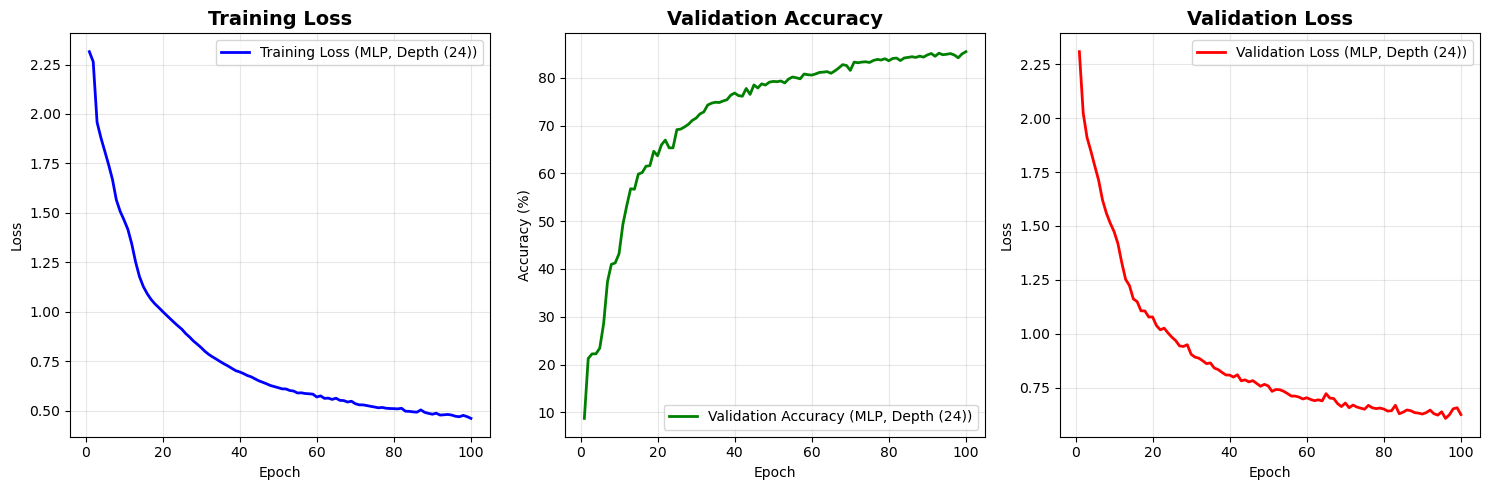

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 86.37%

Classification Report:
              precision    recall  f1-score   support

           0      0.903     0.942     0.922       980
           1      0.979     0.966     0.972      1135
           2      0.895     0.863     0.879      1032
           3      0.675     0.765     0.717      1010
           4      0.867     0.906     0.886       982
           5      0.742     0.715     0.728       892
           6      0.916     0.897     0.906       958
           7      0.969     0.885     0.925      1028
           8      0.831     0.805     0.818       974
           9      0.864     0.865     0.865      1009

    accuracy                          0.864     10000
   macro avg      0.864     0.861     0.862     10000
weighted avg      0.867     0.864     0.865     10000



epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,██▆▆▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▃▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
val_loss,█▆▄▄▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,0.46164
val_accuracy,85.46
val_loss,0.62518


Epoch 0: Train Loss: 2.3076, Val Acc: 11.60%
Epoch 1: Train Loss: 2.3036, Val Acc: 11.60%
Epoch 2: Train Loss: 2.3020, Val Acc: 11.60%
Epoch 3: Train Loss: 2.3015, Val Acc: 11.60%
Epoch 4: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 5: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 6: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 7: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 8: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 9: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 10: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 11: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 12: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 13: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 14: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 15: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 16: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 17: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 18: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 19: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 20: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 21: Train Loss: 2.3013, Val Acc: 11.60

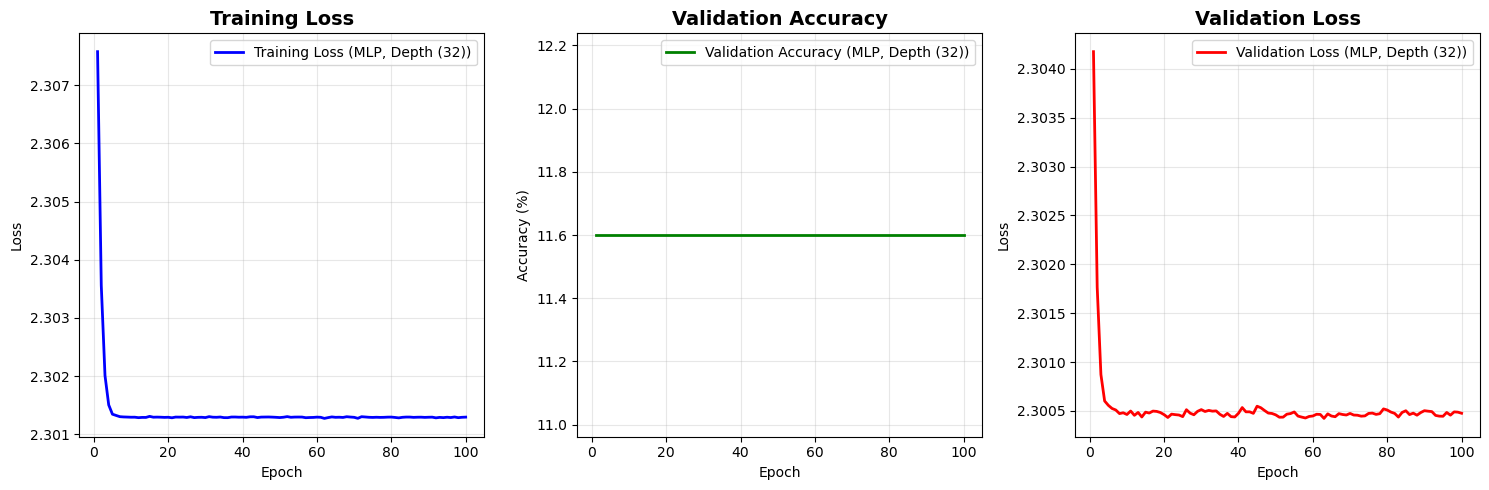

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 11.35%

Classification Report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       980
           1      0.114     1.000     0.204      1135
           2      0.000     0.000     0.000      1032
           3      0.000     0.000     0.000      1010
           4      0.000     0.000     0.000       982
           5      0.000     0.000     0.000       892
           6      0.000     0.000     0.000       958
           7      0.000     0.000     0.000      1028
           8      0.000     0.000     0.000       974
           9      0.000     0.000     0.000      1009

    accuracy                          0.114     10000
   macro avg      0.011     0.100     0.020     10000
weighted avg      0.013     0.114     0.023     10000



epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,2.3013
val_accuracy,11.6
val_loss,2.30048


Epoch 0: Train Loss: 2.3057, Val Acc: 10.60%
Epoch 1: Train Loss: 2.3031, Val Acc: 11.60%
Epoch 2: Train Loss: 2.3020, Val Acc: 11.60%
Epoch 3: Train Loss: 2.3017, Val Acc: 11.60%
Epoch 4: Train Loss: 2.3015, Val Acc: 11.60%
Epoch 5: Train Loss: 2.3014, Val Acc: 11.60%
Epoch 6: Train Loss: 2.3014, Val Acc: 11.60%
Epoch 7: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 8: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 9: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 10: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 11: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 12: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 13: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 14: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 15: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 16: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 17: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 18: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 19: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 20: Train Loss: 2.3013, Val Acc: 11.60%
Epoch 21: Train Loss: 2.3013, Val Acc: 11.60

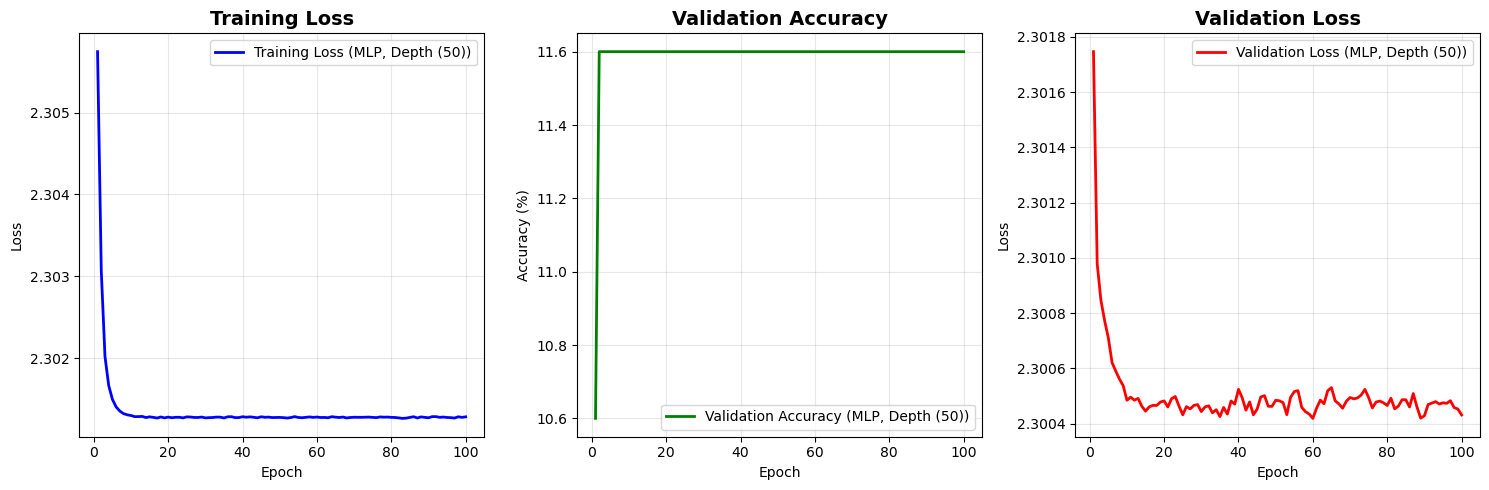

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Accuracy: 11.35%

Classification Report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       980
           1      0.114     1.000     0.204      1135
           2      0.000     0.000     0.000      1032
           3      0.000     0.000     0.000      1010
           4      0.000     0.000     0.000       982
           5      0.000     0.000     0.000       892
           6      0.000     0.000     0.000       958
           7      0.000     0.000     0.000      1028
           8      0.000     0.000     0.000       974
           9      0.000     0.000     0.000      1009

    accuracy                          0.114     10000
   macro avg      0.011     0.100     0.020     10000
weighted avg      0.013     0.114     0.023     10000



epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▄▄▃▃▃▂▂▂▂▃▁▂▂▁▁▃▂▁▂▃▃▃▁▂▂▂▂▃▂▂▃▂▂▂▃▂▁
classification_report,precis...
epoch,100
learning_rate,0.0001
train_loss,2.30128
val_accuracy,11.6
val_loss,2.30043


In [15]:
for depth in depth_values:
    name_run = "lab1_esercizio1.2_MLP - depth: " + str(depth)
    model_MLP = My_Configurable_MLP(input_size, [width]*depth, num_classes).to(device)
    optimizer = torch.optim.Adam(model_MLP.parameters(), lr=lr)
    run = wandb.init(
        project="lab1",
        name=name_run,
        config={
            "model": "MLP",
            "epochs": 100,
            "learning_rate": 0.0001,
            "batch_size": 128,
            "input_size": 28*28,
            "width": width,
            "depth": depth,
            "num_classes": 10,
            "optimizer": "Adam",
            "loss_function": "CrossEntropyLoss"
        }
    )   
    run.watch(model_residual_MLP, log="gradients", log_freq=1)
    train_losses, val_accuracies, val_losses = train(model_MLP, dl_train, dl_val, epochs, criterion, optimizer, device)
    print("MLP")
    plot_training_metrics(train_losses=train_losses,val_accuracies=val_accuracies, val_losses=val_losses, save_path=f"plot/MPL_depth({depth})", model_name="MLP", model_depth=depth)
    (accuracy, _, report) = evaluate(model_MLP, dl_test, device, log_wandb=True)

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'\nClassification Report:\n{report}')
    wandb.finish()








### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving. 

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [16]:
class My_Configurable_CNN(nn.Module):
    def __init__(self, input_size, input_channels, hidden_channels, num_classes):
        super(My_Configurable_CNN, self).__init__()
        self.features = nn.ModuleList()
        layer_input_channels = input_channels
        h, w = input_size
        min_spatial_dim = 4  # Dimensione spaziale minima desiderata

        # Convolutional layers
        for layer_size in hidden_channels[:-1]:  # tutti i layer tranne l'ultimo
            self.features.append(nn.Conv2d(layer_input_channels, layer_size, kernel_size=3, padding=1))
            self.features.append(nn.ReLU())
            self.features.append(nn.MaxPool2d(kernel_size=2, stride=2))

            if h>min_spatial_dim and w>min_spatial_dim:
                h //= 2
                w //= 2
            layer_input_channels = layer_size
            
            
        # Ultimo layer convoluzionale (senza pooling)
        self.final_conv = nn.Conv2d(layer_input_channels, hidden_channels[-1], kernel_size=3, padding=1)
        self.gap = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.classifier = nn.Linear(hidden_channels[-1], num_classes)

    def forward(self, x, return_cam=False):
        # Forward attraverso i layer feature
        for layer in self.features:
            x = layer(x)
            
        # Ultimo layer convoluzionale
        features = self.final_conv(x)  # Salva le feature maps
        
        # GAP e classificazione
        x = self.gap(features)
        x = x.view(x.size(0), -1)
        logits = self.classifier(x)
        
        if return_cam:
            return logits, features
        return logits

    def get_cam(self, features, class_idx):
        # Ottieni i pesi del classificatore per la classe specificata
        weights = self.classifier.weight[class_idx].view(-1, 1, 1)  # Reshape per il broadcasting
    
        # Calcola CAM (moltiplicazione elemento per elemento e somma sui canali)
        # features: (batch_size, channels, h, w)
        # weights: (channels, 1, 1)
        cam = (weights * features).sum(dim=1)  # Somma sui canali
    
        return cam

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        # Proiezione se cambia il numero di canali
        self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.proj(x)
        out = self.conv(x)
        out = self.relu(out)
        out = self.pool(out)
        residual = self.pool(residual)
        return out + residual

class My_Residual_CNN(nn.Module):
    def __init__(self, input_size, input_channels, hidden_channels, num_classes):
        super().__init__()
        self.features = nn.ModuleList()
        h, w = input_size
        in_channels = input_channels
        min_spatial_dim = 4  # Dimensione spaziale minima desiderata

        # Feature extraction layers
        for out_channels in hidden_channels[:-1]:
            self.features.append(ResidualBlock(in_channels, out_channels))

            if h>min_spatial_dim and w>min_spatial_dim:
                h //= 2
                w //= 2
            in_channels = out_channels

        # Final conv layer for CAM
        self.final_conv = ResidualBlock(in_channels, hidden_channels[-1])
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(hidden_channels[-1], num_classes)

    def forward(self, x, return_cam=False):
        # Feature extraction
        for layer in self.features:
            x = layer(x)
            
        # Final conv layer
        features = self.final_conv(x)
        
        # Classification
        x = self.gap(features)
        x = x.flatten(1)
        logits = self.classifier(x)
        
        if return_cam:
            return logits, features
        return logits

    def get_cam(self, features, class_idx):
        weights = self.classifier.weight[class_idx]
        batch_size, channels, h, w = features.shape
        cam = torch.zeros((batch_size, h, w), device=features.device)
        
        for i in range(channels):
            cam += weights[i] * features[:, i, :, :]
            
        return cam

In [18]:
transform_cifar10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

ds_train = CIFAR10(root='./data', train=True, download=True, transform=transform_cifar10)
ds_test = CIFAR10(root='./data', train=False, download=True, transform=transform_cifar10)

val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])



Files already downloaded and verified
Files already downloaded and verified


In [19]:

device = 'cuda' if torch.cuda.is_available else 'cpu'
batch_size = 128
epochs = 50
input_size = (32, 32)  # CIFAR-10 images are 32x32
input_channels = 3  # CIFAR-10 images have 3 channels (RGB)
num_classes = 10
# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

criterion = nn.CrossEntropyLoss()


Epoch 0: Train Loss: 2.2114, Val Acc: 23.60%
Epoch 1: Train Loss: 2.0836, Val Acc: 25.58%
Epoch 2: Train Loss: 2.0406, Val Acc: 27.14%
Epoch 3: Train Loss: 2.0121, Val Acc: 27.90%
Epoch 4: Train Loss: 1.9857, Val Acc: 29.00%
Epoch 5: Train Loss: 1.9575, Val Acc: 30.62%
Epoch 6: Train Loss: 1.9257, Val Acc: 31.88%
Epoch 7: Train Loss: 1.8924, Val Acc: 32.56%
Epoch 8: Train Loss: 1.8601, Val Acc: 34.16%
Epoch 9: Train Loss: 1.8319, Val Acc: 34.52%
Epoch 10: Train Loss: 1.8088, Val Acc: 35.46%
Epoch 11: Train Loss: 1.7914, Val Acc: 35.70%
Epoch 12: Train Loss: 1.7780, Val Acc: 36.66%
Epoch 13: Train Loss: 1.7668, Val Acc: 36.38%
Epoch 14: Train Loss: 1.7581, Val Acc: 37.32%
Epoch 15: Train Loss: 1.7510, Val Acc: 36.84%
Epoch 16: Train Loss: 1.7450, Val Acc: 37.06%
Epoch 17: Train Loss: 1.7398, Val Acc: 37.24%
Epoch 18: Train Loss: 1.7356, Val Acc: 36.92%
Epoch 19: Train Loss: 1.7313, Val Acc: 37.20%
Epoch 20: Train Loss: 1.7281, Val Acc: 37.32%
Epoch 21: Train Loss: 1.7242, Val Acc: 37.74

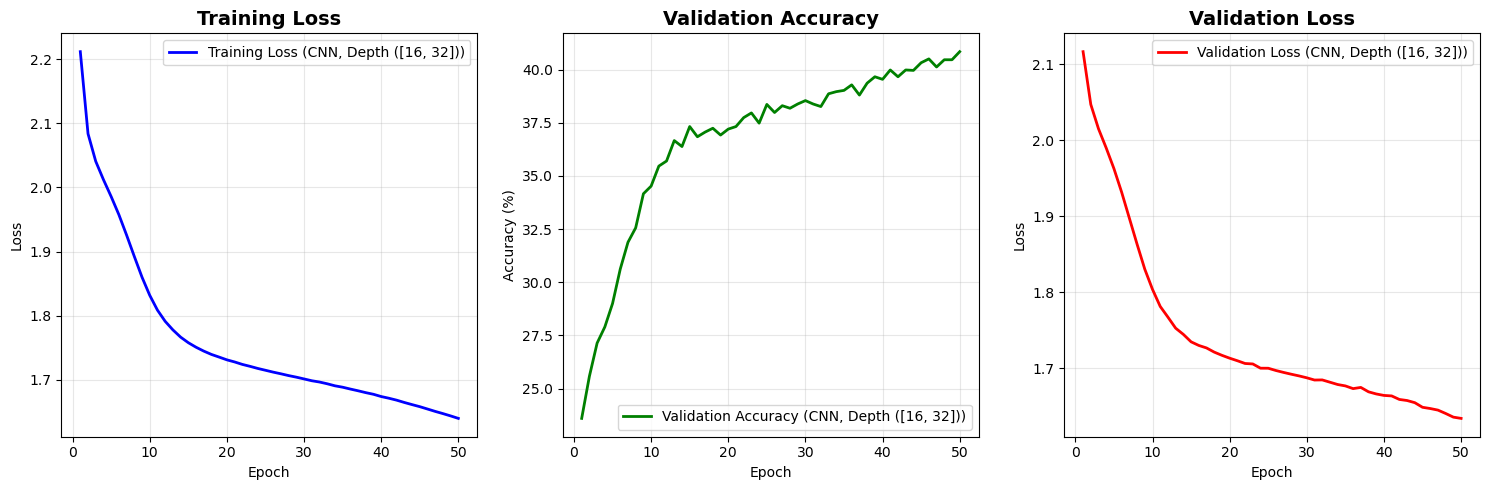

Test Accuracy: 40.26%

Classification Report:
              precision    recall  f1-score   support

           0      0.437     0.446     0.441      1000
           1      0.456     0.512     0.483      1000
           2      0.286     0.234     0.257      1000
           3      0.264     0.244     0.254      1000
           4      0.329     0.315     0.322      1000
           5      0.388     0.417     0.402      1000
           6      0.475     0.517     0.495      1000
           7      0.393     0.317     0.351      1000
           8      0.504     0.578     0.539      1000
           9      0.428     0.446     0.437      1000

    accuracy                          0.403     10000
   macro avg      0.396     0.403     0.398     10000
weighted avg      0.396     0.403     0.398     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▆▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▃▃▄▅▅▅▆▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███████
val_loss,█▇▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,50
learning_rate,0.0001
train_loss,1.64014
val_accuracy,40.84
val_loss,1.63403


Epoch 0: Train Loss: 2.1498, Val Acc: 26.68%
Epoch 1: Train Loss: 1.9542, Val Acc: 32.36%
Epoch 2: Train Loss: 1.8334, Val Acc: 34.72%
Epoch 3: Train Loss: 1.7752, Val Acc: 35.78%
Epoch 4: Train Loss: 1.7366, Val Acc: 35.86%
Epoch 5: Train Loss: 1.7053, Val Acc: 38.16%
Epoch 6: Train Loss: 1.6797, Val Acc: 38.72%
Epoch 7: Train Loss: 1.6582, Val Acc: 38.94%
Epoch 8: Train Loss: 1.6388, Val Acc: 40.10%
Epoch 9: Train Loss: 1.6235, Val Acc: 41.10%
Epoch 10: Train Loss: 1.6082, Val Acc: 41.70%
Epoch 11: Train Loss: 1.5942, Val Acc: 41.96%
Epoch 12: Train Loss: 1.5815, Val Acc: 42.58%
Epoch 13: Train Loss: 1.5712, Val Acc: 42.84%
Epoch 14: Train Loss: 1.5597, Val Acc: 42.96%
Epoch 15: Train Loss: 1.5485, Val Acc: 42.90%
Epoch 16: Train Loss: 1.5386, Val Acc: 44.24%
Epoch 17: Train Loss: 1.5293, Val Acc: 44.14%
Epoch 18: Train Loss: 1.5213, Val Acc: 44.64%
Epoch 19: Train Loss: 1.5112, Val Acc: 45.14%
Epoch 20: Train Loss: 1.5023, Val Acc: 45.88%
Epoch 21: Train Loss: 1.4936, Val Acc: 46.02

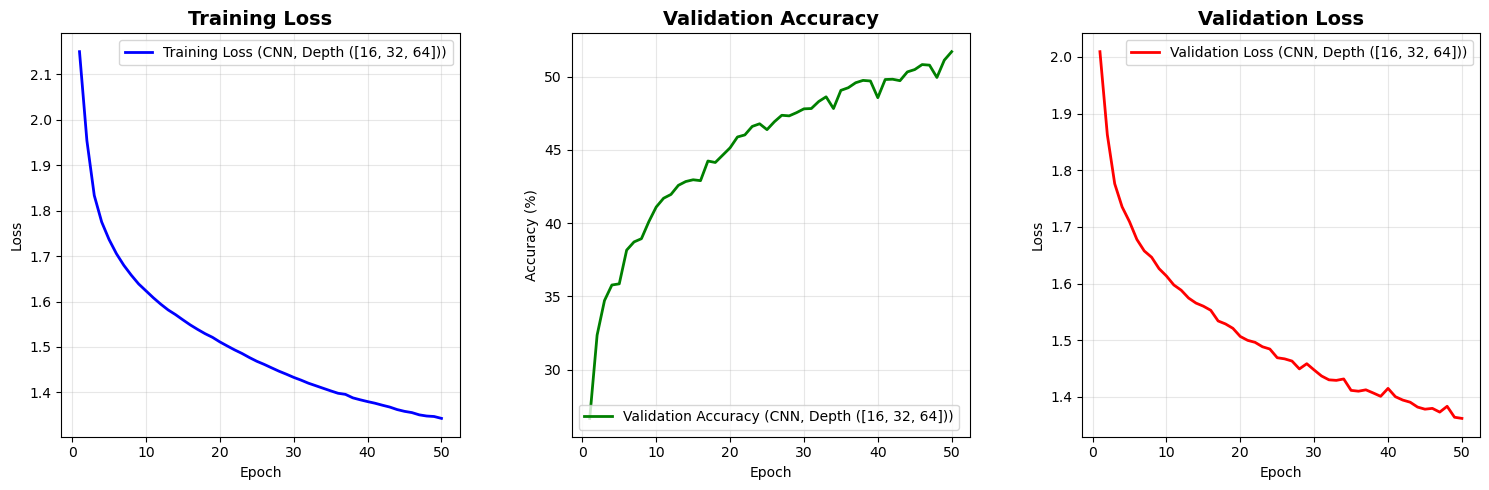

Test Accuracy: 52.03%

Classification Report:
              precision    recall  f1-score   support

           0      0.611     0.409     0.490      1000
           1      0.646     0.612     0.629      1000
           2      0.417     0.395     0.406      1000
           3      0.330     0.306     0.318      1000
           4      0.486     0.382     0.428      1000
           5      0.474     0.497     0.485      1000
           6      0.545     0.713     0.618      1000
           7      0.551     0.573     0.562      1000
           8      0.532     0.721     0.613      1000
           9      0.612     0.595     0.603      1000

    accuracy                          0.520     10000
   macro avg      0.520     0.520     0.515     10000
weighted avg      0.520     0.520     0.515     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████
val_loss,█▆▆▅▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,50
learning_rate,0.0001
train_loss,1.3429
val_accuracy,51.7
val_loss,1.36203


Epoch 0: Train Loss: 2.0427, Val Acc: 33.40%
Epoch 1: Train Loss: 1.7643, Val Acc: 37.84%
Epoch 2: Train Loss: 1.6631, Val Acc: 39.88%
Epoch 3: Train Loss: 1.6170, Val Acc: 40.64%
Epoch 4: Train Loss: 1.5834, Val Acc: 41.82%
Epoch 5: Train Loss: 1.5537, Val Acc: 43.38%
Epoch 6: Train Loss: 1.5309, Val Acc: 44.38%
Epoch 7: Train Loss: 1.5067, Val Acc: 45.76%
Epoch 8: Train Loss: 1.4830, Val Acc: 46.12%
Epoch 9: Train Loss: 1.4621, Val Acc: 47.28%
Epoch 10: Train Loss: 1.4401, Val Acc: 48.50%
Epoch 11: Train Loss: 1.4242, Val Acc: 48.58%
Epoch 12: Train Loss: 1.4079, Val Acc: 49.78%
Epoch 13: Train Loss: 1.3896, Val Acc: 50.82%
Epoch 14: Train Loss: 1.3742, Val Acc: 50.66%
Epoch 15: Train Loss: 1.3607, Val Acc: 50.74%
Epoch 16: Train Loss: 1.3510, Val Acc: 51.78%
Epoch 17: Train Loss: 1.3352, Val Acc: 51.90%
Epoch 18: Train Loss: 1.3244, Val Acc: 51.94%
Epoch 19: Train Loss: 1.3149, Val Acc: 53.10%
Epoch 20: Train Loss: 1.2997, Val Acc: 53.04%
Epoch 21: Train Loss: 1.2935, Val Acc: 53.06

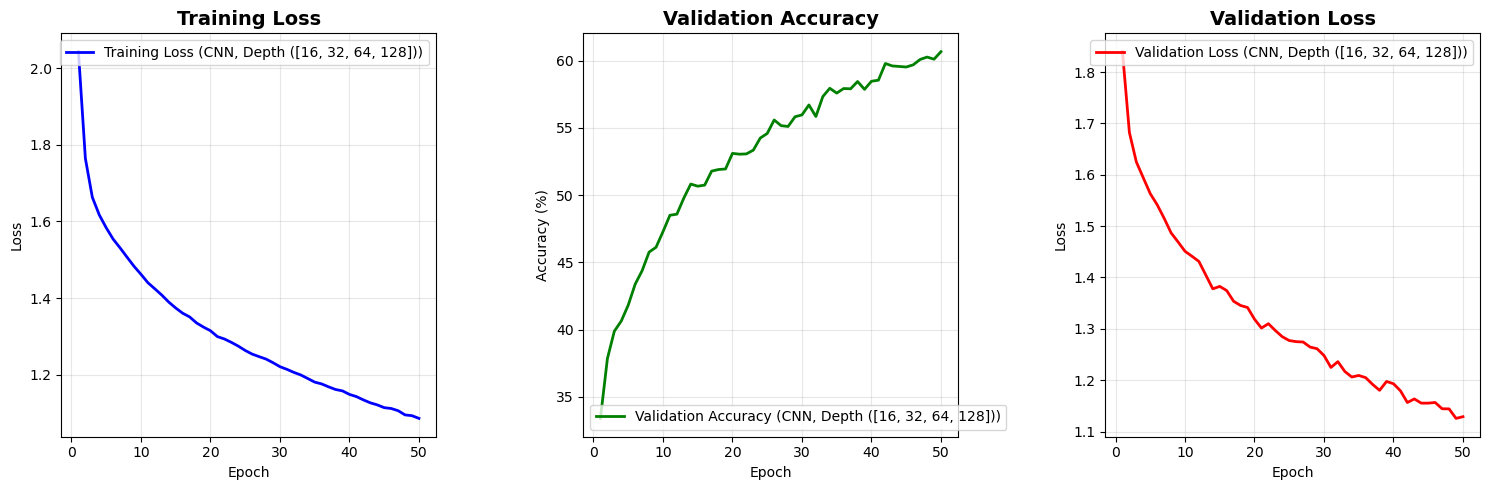

Test Accuracy: 60.13%

Classification Report:
              precision    recall  f1-score   support

           0      0.606     0.671     0.637      1000
           1      0.715     0.756     0.735      1000
           2      0.520     0.467     0.492      1000
           3      0.460     0.260     0.332      1000
           4      0.511     0.509     0.510      1000
           5      0.484     0.587     0.530      1000
           6      0.727     0.659     0.691      1000
           7      0.564     0.729     0.636      1000
           8      0.780     0.646     0.707      1000
           9      0.643     0.729     0.684      1000

    accuracy                          0.601     10000
   macro avg      0.601     0.601     0.595     10000
weighted avg      0.601     0.601     0.595     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▂▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████
val_loss,██▆▆▆▅▅▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,50
learning_rate,0.0001
train_loss,1.08637
val_accuracy,60.66
val_loss,1.12889


Epoch 0: Train Loss: 1.9244, Val Acc: 38.14%
Epoch 1: Train Loss: 1.6295, Val Acc: 42.36%
Epoch 2: Train Loss: 1.5348, Val Acc: 44.70%
Epoch 3: Train Loss: 1.4804, Val Acc: 46.40%
Epoch 4: Train Loss: 1.4324, Val Acc: 48.70%
Epoch 5: Train Loss: 1.3867, Val Acc: 49.84%
Epoch 6: Train Loss: 1.3533, Val Acc: 51.78%
Epoch 7: Train Loss: 1.3140, Val Acc: 51.66%
Epoch 8: Train Loss: 1.2809, Val Acc: 54.72%
Epoch 9: Train Loss: 1.2511, Val Acc: 55.44%
Epoch 10: Train Loss: 1.2243, Val Acc: 56.04%
Epoch 11: Train Loss: 1.1985, Val Acc: 56.70%
Epoch 12: Train Loss: 1.1748, Val Acc: 58.14%
Epoch 13: Train Loss: 1.1523, Val Acc: 57.32%
Epoch 14: Train Loss: 1.1298, Val Acc: 58.36%
Epoch 15: Train Loss: 1.1104, Val Acc: 59.26%
Epoch 16: Train Loss: 1.0895, Val Acc: 59.56%
Epoch 17: Train Loss: 1.0693, Val Acc: 61.16%
Epoch 18: Train Loss: 1.0534, Val Acc: 61.40%
Epoch 19: Train Loss: 1.0312, Val Acc: 61.86%
Epoch 20: Train Loss: 1.0210, Val Acc: 60.92%
Epoch 21: Train Loss: 0.9983, Val Acc: 63.18

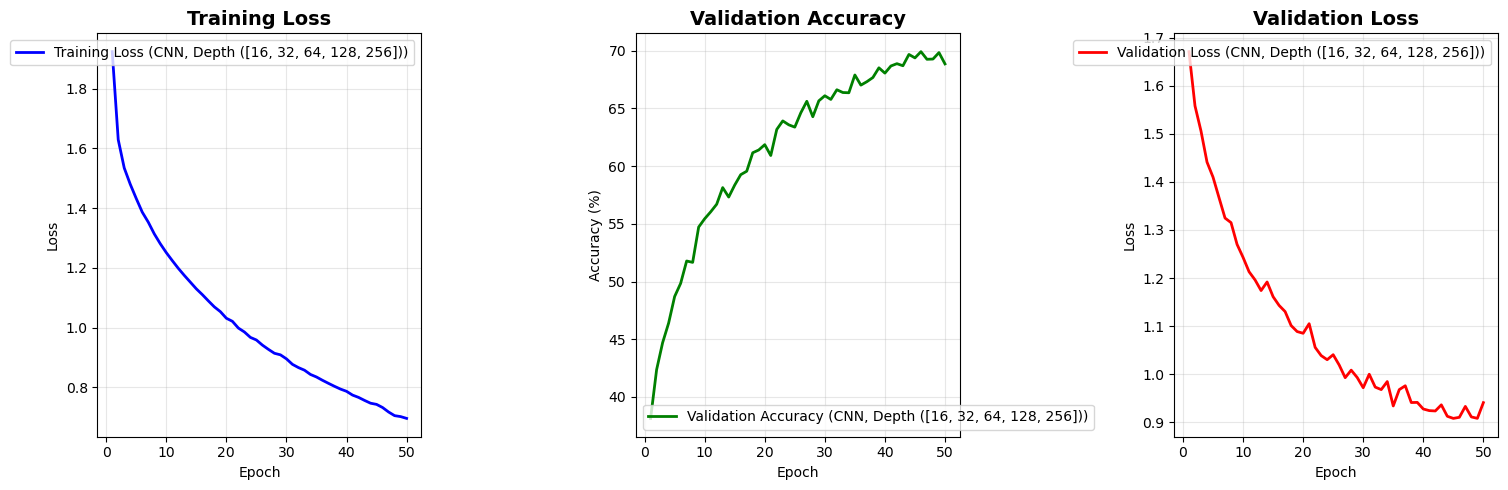

Test Accuracy: 69.08%

Classification Report:
              precision    recall  f1-score   support

           0      0.703     0.787     0.742      1000
           1      0.787     0.829     0.807      1000
           2      0.606     0.612     0.609      1000
           3      0.462     0.586     0.517      1000
           4      0.788     0.447     0.571      1000
           5      0.564     0.640     0.600      1000
           6      0.689     0.836     0.755      1000
           7      0.816     0.655     0.727      1000
           8      0.846     0.783     0.814      1000
           9      0.811     0.733     0.770      1000

    accuracy                          0.691     10000
   macro avg      0.707     0.691     0.691     10000
weighted avg      0.707     0.691     0.691     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████
val_loss,█▆▆▅▅▅▄▄▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
classification_report,precis...
epoch,50
learning_rate,0.0001
train_loss,0.69569
val_accuracy,68.86
val_loss,0.94085


Epoch 0: Train Loss: 1.9423, Val Acc: 35.56%
Epoch 1: Train Loss: 1.6183, Val Acc: 42.48%
Epoch 2: Train Loss: 1.5217, Val Acc: 42.10%
Epoch 3: Train Loss: 1.4538, Val Acc: 47.46%
Epoch 4: Train Loss: 1.3977, Val Acc: 48.06%
Epoch 5: Train Loss: 1.3525, Val Acc: 50.92%
Epoch 6: Train Loss: 1.3089, Val Acc: 52.40%
Epoch 7: Train Loss: 1.2664, Val Acc: 54.44%
Epoch 8: Train Loss: 1.2269, Val Acc: 54.56%
Epoch 9: Train Loss: 1.1941, Val Acc: 57.34%
Epoch 10: Train Loss: 1.1562, Val Acc: 57.74%
Epoch 11: Train Loss: 1.1350, Val Acc: 59.22%
Epoch 12: Train Loss: 1.0954, Val Acc: 58.40%
Epoch 13: Train Loss: 1.0687, Val Acc: 61.46%
Epoch 14: Train Loss: 1.0406, Val Acc: 61.82%
Epoch 15: Train Loss: 1.0150, Val Acc: 61.90%
Epoch 16: Train Loss: 0.9920, Val Acc: 61.32%
Epoch 17: Train Loss: 0.9668, Val Acc: 62.90%
Epoch 18: Train Loss: 0.9430, Val Acc: 63.54%
Epoch 19: Train Loss: 0.9278, Val Acc: 65.02%
Epoch 20: Train Loss: 0.9065, Val Acc: 65.68%
Epoch 21: Train Loss: 0.8864, Val Acc: 65.80

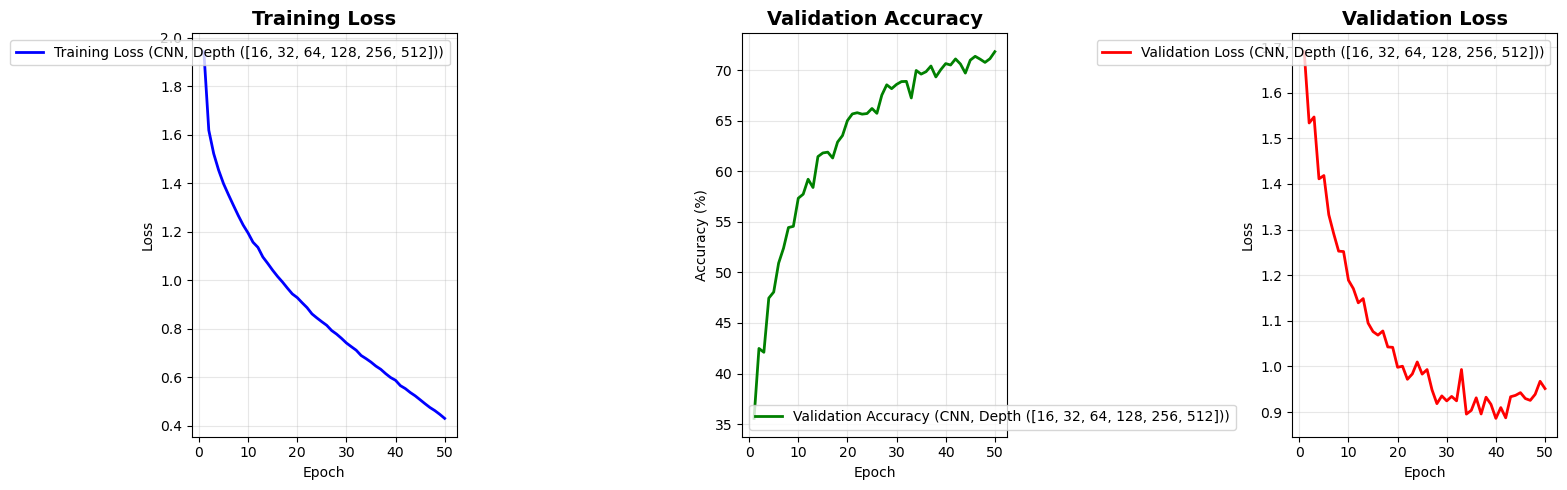

Test Accuracy: 70.84%

Classification Report:
              precision    recall  f1-score   support

           0      0.782     0.723     0.752      1000
           1      0.807     0.800     0.804      1000
           2      0.623     0.582     0.602      1000
           3      0.532     0.546     0.539      1000
           4      0.693     0.642     0.666      1000
           5      0.600     0.611     0.606      1000
           6      0.728     0.821     0.772      1000
           7      0.752     0.742     0.747      1000
           8      0.845     0.804     0.824      1000
           9      0.730     0.813     0.769      1000

    accuracy                          0.708     10000
   macro avg      0.709     0.708     0.708     10000
weighted avg      0.709     0.708     0.708     10000



wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▂▂▃▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████
val_loss,█▇▇▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂
classification_report,precis...
epoch,50
learning_rate,0.0001
train_loss,0.42953
val_accuracy,71.84
val_loss,0.9515


RuntimeError: Given input size: (512x1x1). Calculated output size: (512x0x0). Output size is too small

In [20]:
from sklearn.metrics import accuracy_score, classification_report
depth_configs = {
    'shallow': [16, 32],
    'medium': [16, 32, 64],
    'deep': [16, 32, 64, 128],
    'very_deep': [16, 32, 64, 128, 256],
    'ultra_deep': [16, 32, 64, 128, 256, 512],
    'extreme_deep': [16, 32, 64, 128, 256, 512, 1024]
}

for depth_name, hidden_channels in depth_configs.items():
    model_CNN = My_Configurable_CNN(input_size, input_channels, hidden_channels, num_classes).to(device)
    lr = 0.0001
    optimizer = torch.optim.Adam(model_CNN.parameters(), lr=lr)
    name_run = f"lab1_esercizio1.3 - {depth_name} CNN "
    run = wandb.init(
        project="DLALabs",
        name=name_run,
        config={
            "model": "CNN",
            "epochs": 50,
            "learning_rate": 0.0001,
            "batch_size": 128,
            "input_size": 28*28,
            "input_channels": input_channels,
            "hidden_channels": hidden_channels,
            "num_classes": 10,
            "optimizer": "Adam",
            "loss_function": "CrossEntropyLoss"
        }
    )
    run.watch(model_CNN, log="gradients", log_freq=1)
    train_losses, val_accuracies, val_losses = train(model_CNN, dl_train, dl_val, epochs, criterion, optimizer, device)
    print("CNN")
    plot_training_metrics(train_losses=train_losses,val_accuracies=val_accuracies, val_losses=val_losses, save_path=f"plot/CNN({depth_name})", model_name="CNN", model_depth=hidden_channels)
    (accuracy, _, report) = evaluate(model_CNN, dl_test, device, log_wandb=True)

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'\nClassification Report:\n{report}')

    model_path = f"model_CNN_{depth_name}.pth"
    torch.save({
        'model_state_dict': model_CNN.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': accuracy,
        'hidden_channels': hidden_channels,
    }, model_path)

    artifact = wandb.Artifact(
        name=f"model_CNN_{depth_name}", 
        type="model",
        description=f"CNN model with {hidden_channels} depth"
    )
    artifact.add_file(model_path)
    wandb.log_artifact(artifact)
    wandb.finish()








In [ ]:
from sklearn.metrics import accuracy_score, classification_report
depth_configs = {
    'shallow': [16, 32],
    'medium': [16, 32, 64],
    'deep': [16, 32, 64, 128],
    'very_deep': [16, 32, 64, 128, 256],
    'ultra_deep': [16, 32, 64, 128, 256, 512],
    'extreme_deep': [16, 32, 64, 128, 256, 512, 1024]
}

for depth_name, hidden_channels in depth_configs.items():
    model_Residual_CNN = My_Residual_CNN(input_size, input_channels, hidden_channels, num_classes).to(device)
    lr = 0.0001
    optimizer = torch.optim.Adam(model_Residual_CNN.parameters(), lr=lr)
    name_run = f"lab1_esercizio1.3 - {depth_name} Residual CNN "
    run = wandb.init(
        project="DLALabs",
        name=name_run,
        config={
            "model": "Residual CNN",
            "epochs": 50,
            "learning_rate": 0.0001,
            "batch_size": 128,
            "input_size": 28*28,
            "input_channels": input_channels,
            "hidden_channels": hidden_channels,
            "num_classes": 10,
            "optimizer": "Adam",
            "loss_function": "CrossEntropyLoss"
        }
    )
    run.watch(model_Residual_CNN, log="gradients", log_freq=1)
    train_losses, val_accuracies, val_losses = train(model_Residual_CNN, dl_train, dl_val, epochs, criterion, optimizer, device)
    print("CNN")
    plot_training_metrics(train_losses=train_losses,val_accuracies=val_accuracies, val_losses=val_losses, save_path=f"plot/Residual_CNN_{depth_name}", model_name="CNN", model_depth=hidden_channels)
    (accuracy, _, report) = evaluate(model_Residual_CNN, dl_test, device, log_wandb=True)

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'\nClassification Report:\n{report}')

    model_path = f"model_Residual_CNN_{depth_name}.pth"
    torch.save({
        'model_state_dict': model_Residual_CNN.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'accuracy': accuracy,
        'hidden_channels': hidden_channels,
    }, model_path)

    artifact = wandb.Artifact(
        name=f"model_Residual_CNN_{depth_name}", 
        type="model",
        description=f"Residual CNN model with {hidden_channels} depth"
    )
    artifact.add_file(model_path)
    wandb.log_artifact(artifact)

    wandb.finish()








-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit. Each exercise is designed to require you to dig your hands **deep** into the guts of your models in order to do new and interesting things.

**Note**: These exercises are designed to use your small, custom CNNs and small datasets. This is to keep training times reasonable. If you have a decent GPU, feel free to use pretrained ResNets and larger datasets (e.g. the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset at 160px).

### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

In [ ]:
# Your code here.

### Exercise 2.2: *Distill* the knowledge from a large model into a smaller one
In this exercise you will see if you can derive a *small* model that performs comparably to a larger one on CIFAR-10. To do this, you will use [Knowledge Distillation](https://arxiv.org/abs/1503.02531):

> Geoffrey Hinton, Oriol Vinyals, and Jeff Dean. Distilling the Knowledge in a Neural Network, NeurIPS 2015.

To do this:
1. Train one of your best-performing CNNs on CIFAR-10 from Exercise 1.3 above. This will be your **teacher** model.
2. Define a *smaller* variant with about half the number of parameters (change the width and/or depth of the network). Train it on CIFAR-10 and verify that it performs *worse* than your **teacher**. This small network will be your **student** model.
3. Train the **student** using a combination of **hard labels** from the CIFAR-10 training set (cross entropy loss) and **soft labels** from predictions of the **teacher** (Kulback-Leibler loss between teacher and student).

Try to optimize training parameters in order to maximize the performance of the student. It should at least outperform the student trained only on hard labels in Setp 2.

**Tip**: You can save the predictions of the trained teacher network on the training set and adapt your dataloader to provide them together with hard labels. This will **greatly** speed up training compared to performing a forward pass through the teacher for each batch of training.

In [ ]:
# Your code here.

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.3 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your CNN implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes. Try your implementation out using a pre-trained ResNet-18 model and some images from the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset -- I suggest you start with the low resolution version of images at 160px.

In [ ]:
def cam_results(image, cam, predicted_class, true_label, confidence, dataset_classes):

    # Prepara dati per visualizzazione
    img_np = image[0].cpu().permute(1, 2, 0).numpy()
    cam_np = cam[0, 0].cpu().detach().numpy()
    
    # Normalizza immagine se necessario
    if img_np.min() < 0:  # Se è normalizzata [-1,1] o simile
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    
    # Layout migliorato con 3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 1. Immagine originale
    axes[0].imshow(img_np)
    axes[0].set_title(f'Original Image\nTrue: {dataset_classes[true_label]}', fontsize=12)
    axes[0].axis('off')
    
    # 2. CAM
    im = axes[1].imshow(cam_np, cmap='jet')
    axes[1].set_title(f'Class Activation Map\nPred: {dataset_classes[predicted_class]}', fontsize=12)
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046)
    
    # 3. Overlay migliorato
    axes[2].imshow(img_np)
    axes[2].imshow(cam_np, alpha=0.5, cmap='jet')
    axes[2].set_title(f'CAM Overlay\nConfidence: {confidence:.3f}', fontsize=12)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Statistiche CAM
    print(f"\n CAM Statistics:")
    print(f"CAM shape: {cam_np.shape}")
    print(f"CAM range: [{cam_np.min():.4f}, {cam_np.max():.4f}]")
    print(f"CAM mean: {cam_np.mean():.4f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                      'dog', 'frog', 'horse', 'ship', 'truck']
# Carica immagine e modello
#image = CIFAR10(root='./data', train=False, download=True, transform=transform_cifar10)[0][0].unsqueeze(0)
dataset = CIFAR10(root='./data', train=False, download=True, transform=transform_cifar10)
image_idx = np.random.randint(0, len(dataset))  # Immagine casuale
image, true_label = dataset[image_idx]
image = image.unsqueeze(0).to(device)
print(f"Testing on image {image_idx}, true class: {CIFAR10_CLASSES[true_label]}")

# Carica il checkpoint salvato
checkpoint = torch.load('model_CNN_very_deep.pth')

# Ricrea il modello con la stessa architettura
model = My_Configurable_CNN(
    input_size=(32, 32),
    input_channels=3, 
    hidden_channels=checkpoint['hidden_channels'],
    num_classes=10
).to(device)

# Carica i pesi salvati
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Sposta immagine su device
image = image.to(device)

# Forward pass per ottenere predizioni e features
logits, features = model(image, return_cam=True)
predicted_class = logits.argmax(dim=1)
confidence = F.softmax(logits, dim=1)[0][predicted_class].item()
            
print(f"Predicted: {CIFAR10_CLASSES[predicted_class]} (confidence: {confidence:.3f})")
print(f"True label: {CIFAR10_CLASSES[true_label]}")

# Genera CAM
cam = model.get_cam(features, predicted_class)
cam = F.relu(cam)  # ReLU per evidenziare solo contributi positivi
cam = cam - cam.min()
cam = cam / cam.max()

# Ridimensiona CAM alle dimensioni dell'immagine originale
cam_resized = F.interpolate(
            cam.unsqueeze(1), 
            size=image.shape[2:], 
            mode='bilinear', 
            align_corners=False
        )

cam_results(image, cam_resized, predicted_class, true_label, confidence, CIFAR10_CLASSES)


In [ ]:
import torchvision.models as models

class CAM_ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(CAM_ResNet18, self).__init__()
        
        # Carica ResNet-18 pretrainata
        resnet = models.resnet18(pretrained=True)
        
        # Estrai le features (tutto tranne avgpool e fc)
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        
        # GAP e nuovo classificatore per Imagenette
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(512, num_classes)  # ResNet-18 ha 512 features
        
        # Inizializza il nuovo classificatore
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)
    
    def forward(self, x, return_cam=False):
        # Features da ResNet backbone
        features = self.features(x)  # [batch, 512, h, w]
        
        # GAP e classificazione
        pooled = self.gap(features)
        pooled = pooled.view(pooled.size(0), -1)
        logits = self.classifier(pooled)
        
        if return_cam:
            return logits, features
        return logits
    
    def get_cam(self, features, class_idx):
        """Genera CAM per una classe specifica"""
        weights = self.classifier.weight[class_idx].view(-1, 1, 1)
        cam = (weights * features).sum(dim=1)  # [batch, h, w]
        return cam

In [ ]:
from torchvision.datasets import Imagenette

transform_imagenette = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])

IMAGENETTE_CLASSES = [
        'tench', 'English springer', 'cassette player', 'chain saw', 'church',
        'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute'
    ]

dataset = Imagenette(root='./data', split='val', size='160px', 
                           download=False, transform=transform_imagenette)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

image_idx = np.random.randint(0, len(dataset))  # Immagine casuale
image, true_label = dataset[image_idx]
image = image.unsqueeze(0).to(device)
print(f"Testing on image {image_idx}, true class: {IMAGENETTE_CLASSES[true_label]}")

model = CAM_ResNet18(num_classes=len(IMAGENETTE_CLASSES)).to(device)
model.eval()
image = image.to(device)
# Forward pass per ottenere predizioni e features
logits, features = model(image, return_cam=True)
predicted_class = logits.argmax(dim=1)
confidence = F.softmax(logits, dim=1)[0][predicted_class].item()
            
print(f"Predicted: {IMAGENETTE_CLASSES[predicted_class]} (confidence: {confidence:.3f})")
print(f"True label: {IMAGENETTE_CLASSES[true_label]}")

# Genera CAM
cam = model.get_cam(features, predicted_class)
cam = F.relu(cam)  # ReLU per evidenziare solo contributi positivi
cam = cam - cam.min()
cam = cam / cam.max()

# Ridimensiona CAM alle dimensioni dell'immagine originale
cam_resized = F.interpolate(
            cam.unsqueeze(1), 
            size=image.shape[2:], 
            mode='bilinear', 
            align_corners=False
        )

cam_results(image, cam_resized, predicted_class, true_label, confidence,IMAGENETTE_CLASSES)